In [ ]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 675, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 675 (delta 172), reused 249 (delta 133), pack-reused 355 (from 1)
Receiving objects: 100% (675/675), 81.98 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (303/303), done.


In [ ]:
cd Tidal_try

/content/Tidal_try


Selected start index: 769
Single-feature TrainX: (9950, 50, 1) TrainY: (9950, 1)
Single-feature TestX: (3000, 50, 1) TestY: (3000, 1)
Multi-feature TrainX: (9950, 50, 2) TrainY: (9950,)
Multi-feature TestX: (3000, 50, 2) TestY: (3000,)
Training LSTM_single (utide_factor=0.6)...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1555 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0417 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0251 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0194 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0171 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0155 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0142 -

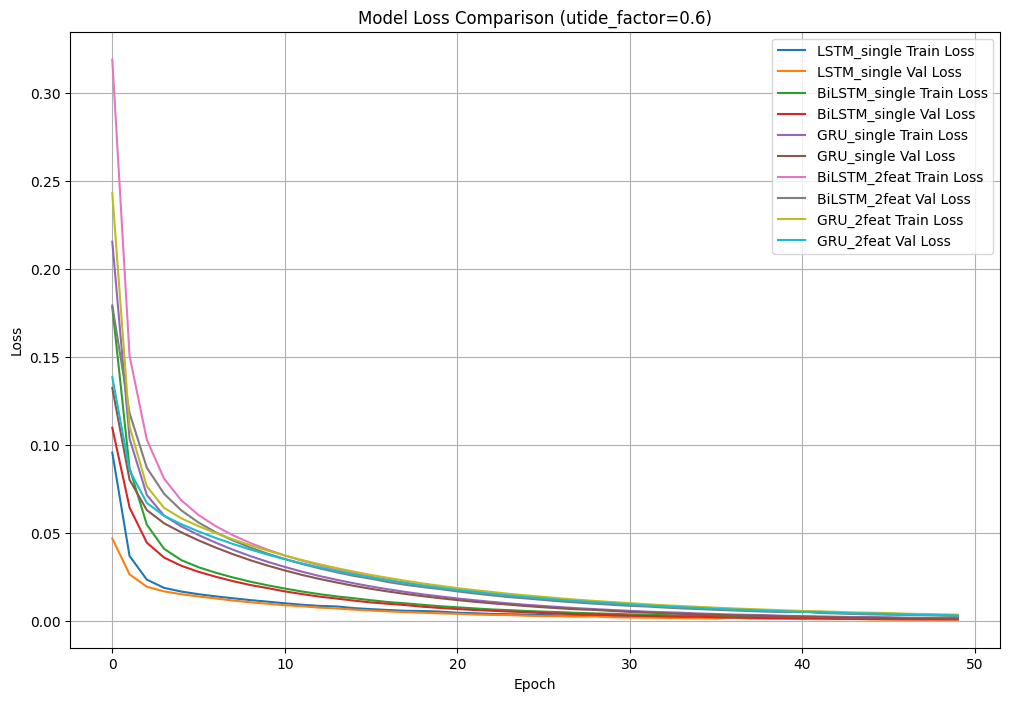

Performing rolling prediction with LSTM_single...
LSTM_single rolling prediction completed.

Performing rolling prediction with BiLSTM_single...
BiLSTM_single rolling prediction completed.

Performing rolling prediction with GRU_single...
GRU_single rolling prediction completed.

Performing rolling prediction with BiLSTM_2feat...
BiLSTM_2feat rolling prediction completed.

Performing rolling prediction with GRU_2feat...
GRU_2feat rolling prediction completed.



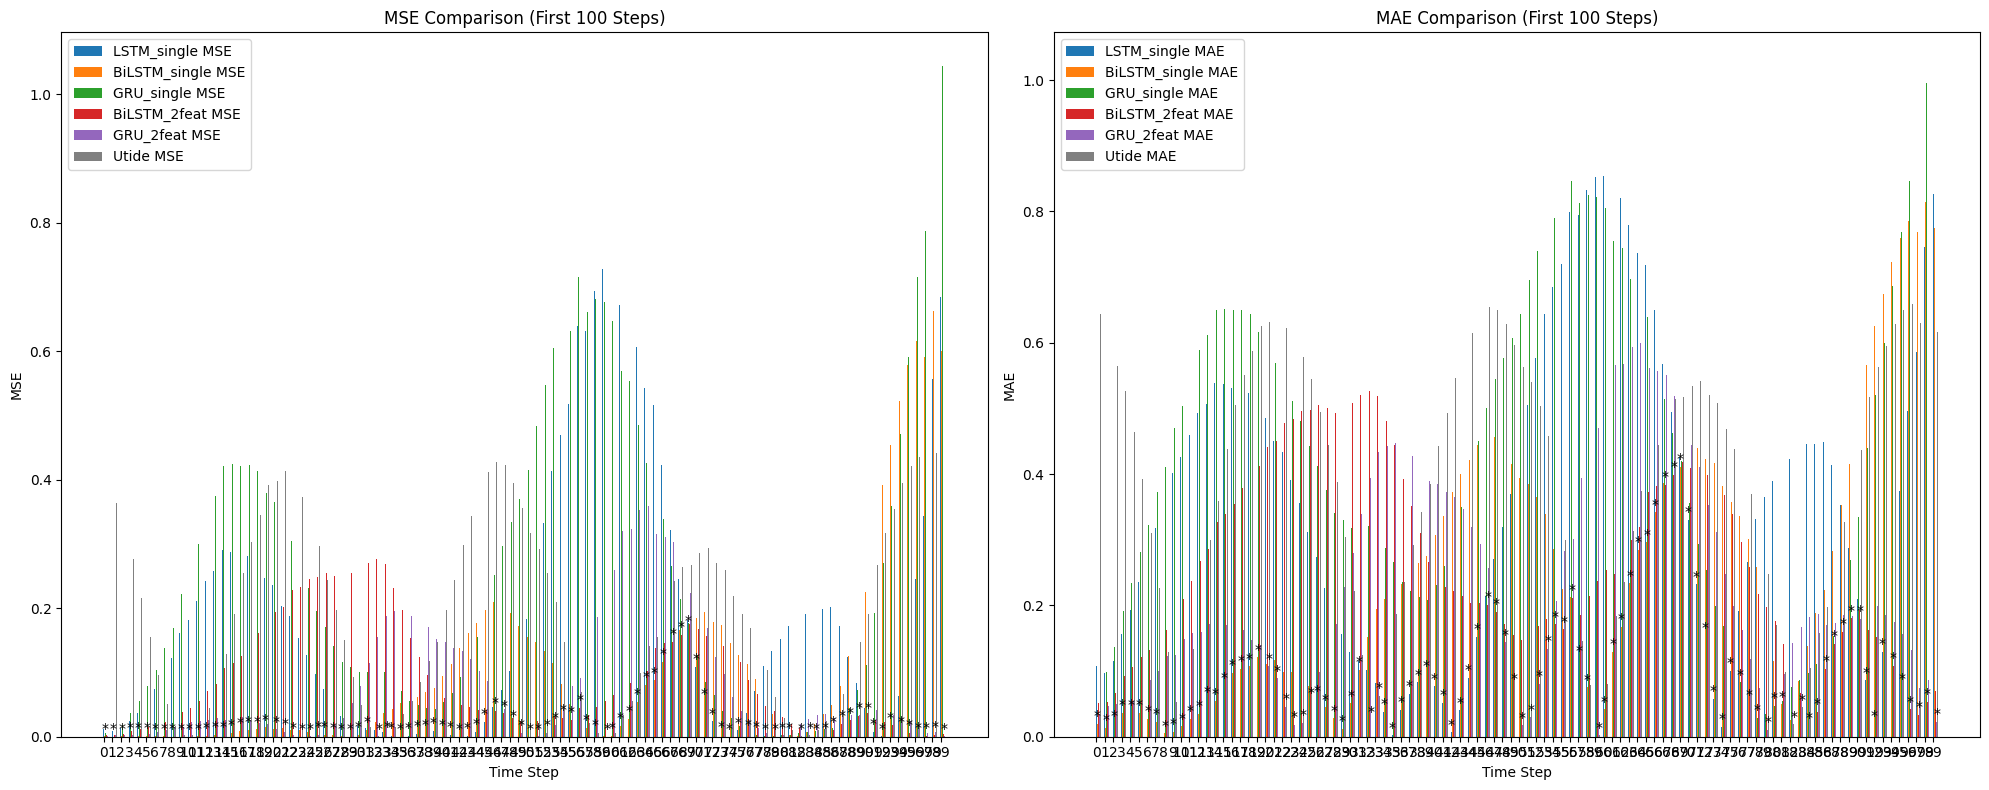

LSTM_single R² falls below Utide at step: 104
BiLSTM_single R² falls below Utide at step: 197
GRU_single R² falls below Utide at step: 31
BiLSTM_2feat R² falls below Utide at step: 189
GRU_2feat R² falls below Utide at step: Never


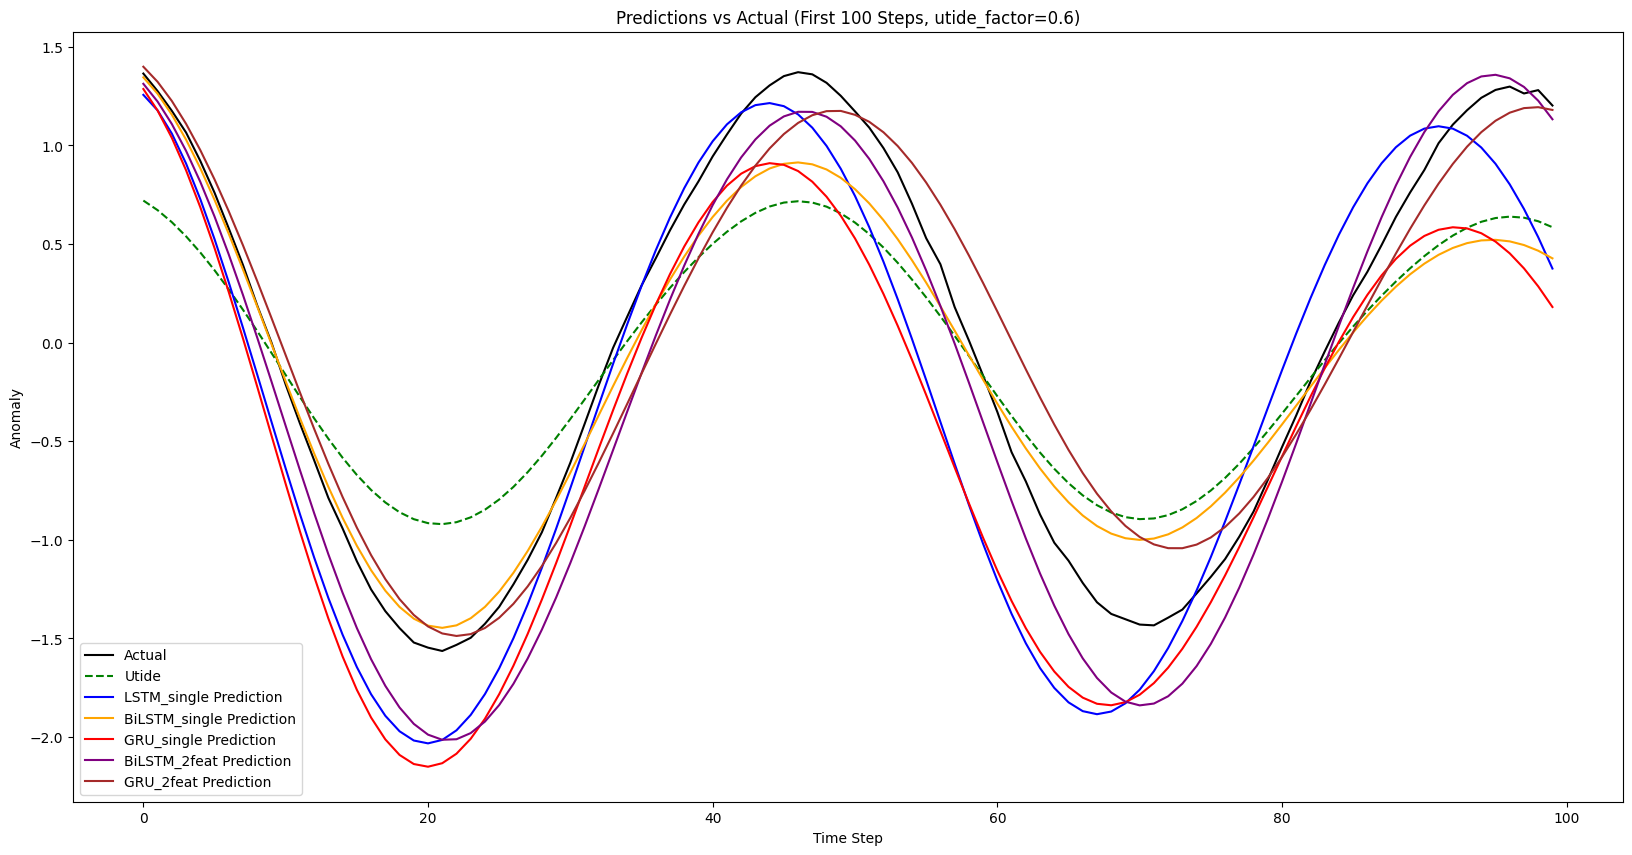

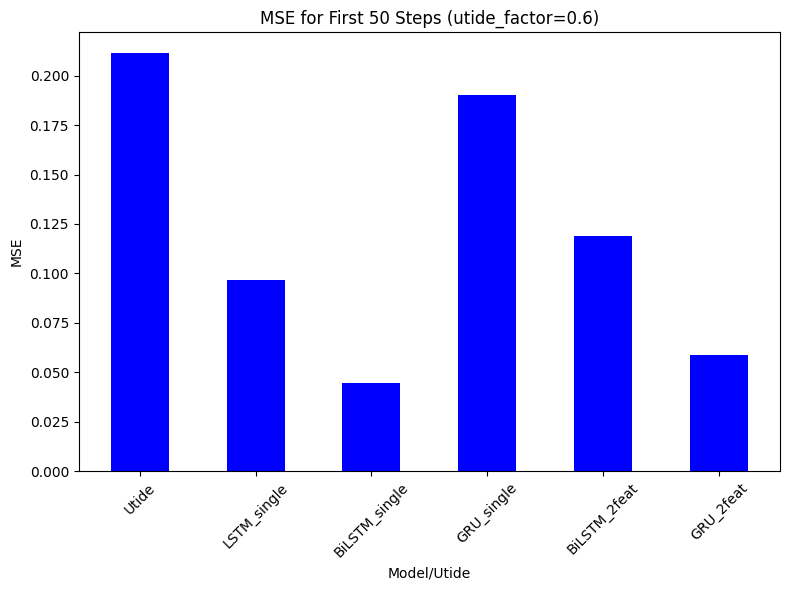

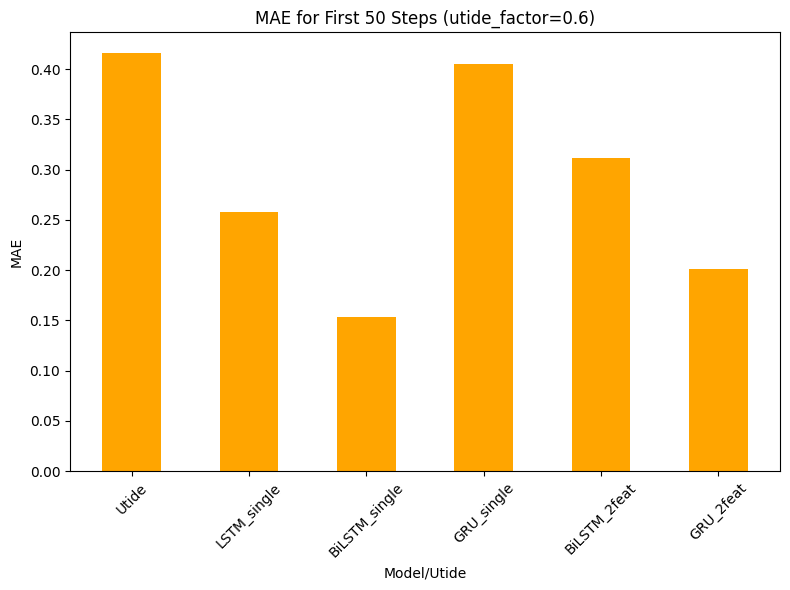

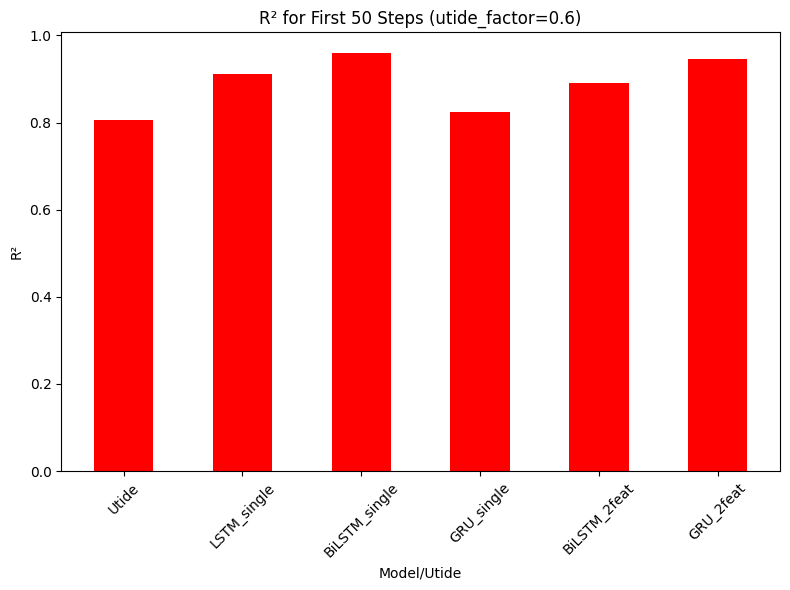

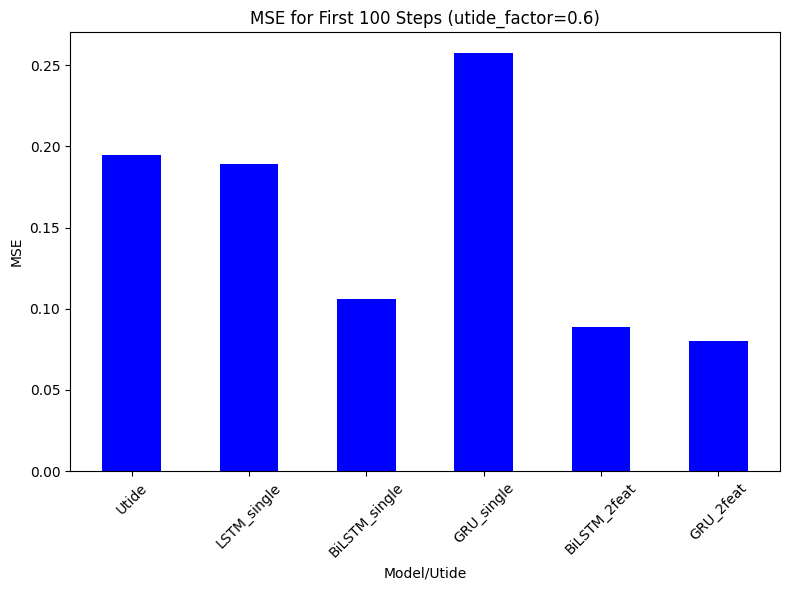

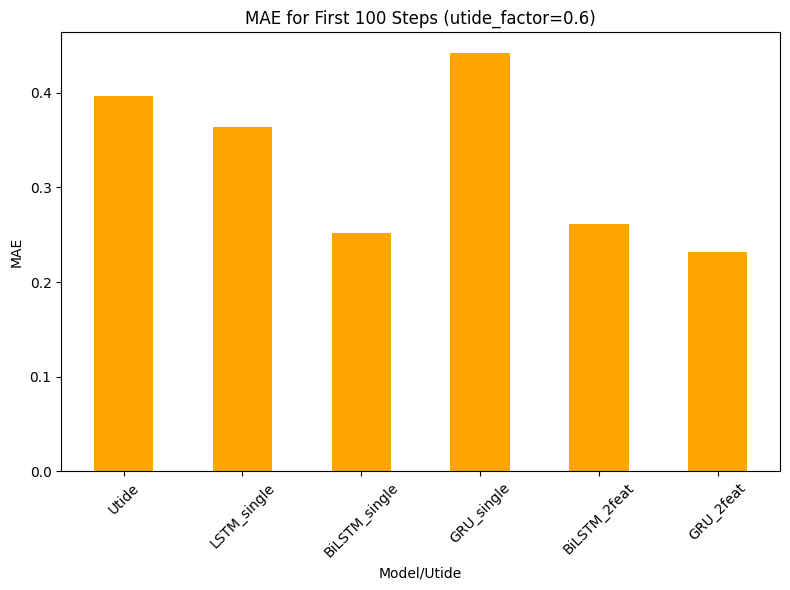

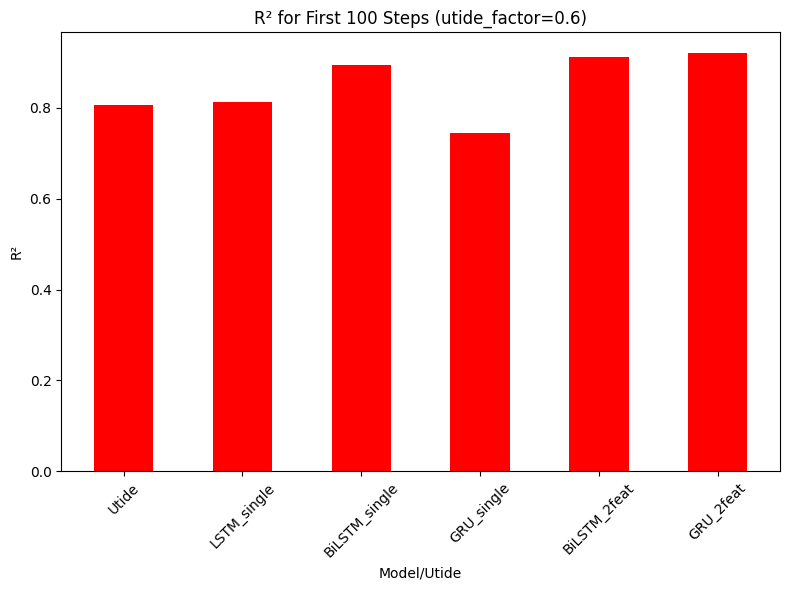

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Model
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import tensorflow as tf

# np.random.seed(42)
# tf.random.set_seed(42)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = pd.read_csv(input_file, delimiter=',')
total_train_points = 10000
look_back_points = 50
total_test_points = 3000

total_required = total_train_points + look_back_points + total_test_points
if len(df) < total_required:
    raise ValueError(f"Dataset too small. Required: {total_required}, Current: {len(df)}")

max_start_index = len(df) - total_required
start_index = np.random.randint(0, max_start_index + 1)
print(f"Selected start index: {start_index}")

df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)

anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide_original = df_sampled['utide'].values.reshape(-1, 1)

utide_factor = 0.6
utide = utide_original * utide_factor

data = np.hstack((anomaly, utide))
scaler_all = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler_all.fit_transform(data)

anomaly_scaled = data_scaled[:,0:1]
utide_scaled = data_scaled[:,1:2]

#（仅 anomaly）
dataset_scaled_single = anomaly_scaled
train_single = dataset_scaled_single[:total_train_points]
test_single = dataset_scaled_single[total_train_points : total_train_points + total_test_points + look_back_points]

#（anomaly + utide）
dataset_scaled_multi = data_scaled
train_multi = dataset_scaled_multi[:total_train_points]
test_multi = dataset_scaled_multi[total_train_points : total_train_points + total_test_points + look_back_points]

def create_dataset_single(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

def create_dataset_multi(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX_single, trainY_single = create_dataset_single(train_single, look_back_points)
testX_single, testY_single = create_dataset_single(test_single, look_back_points)

trainX_multi, trainY_multi = create_dataset_multi(train_multi, look_back_points)
testX_multi, testY_multi = create_dataset_multi(test_multi, look_back_points)

print("Single-feature TrainX:", trainX_single.shape, "TrainY:", trainY_single.shape)
print("Single-feature TestX:", testX_single.shape, "TestY:", testY_single.shape)
print("Multi-feature TrainX:", trainX_multi.shape, "TrainY:", trainY_multi.shape)
print("Multi-feature TestX:", testX_multi.shape, "TestY:", testY_multi.shape)

num_features_single = 1
num_features_multi = 2

# 定义辅助函数进行逆归一化
def inverse_anomaly(value_scaled):
    temp = np.zeros((1,2))
    temp[0,0] = value_scaled
    original = scaler_all.inverse_transform(temp)
    return original[0,0]

def inverse_utide(value_scaled):
    temp = np.zeros((1,2))
    temp[0,1] = value_scaled
    original = scaler_all.inverse_transform(temp)
    return original[0,1]

def inverse_array_anomaly(arr_scaled):
    temp = np.zeros((len(arr_scaled), 2))
    temp[:,0] = arr_scaled
    original = scaler_all.inverse_transform(temp)
    return original[:,0]

def inverse_array_utide(arr_scaled):
    temp = np.zeros((len(arr_scaled), 2))
    temp[:,1] = arr_scaled
    original = scaler_all.inverse_transform(temp)
    return original[:,1]

# model
def build_lstm_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(500, return_sequences=True, kernel_regularizer=l2(0.0001))(input_layer)
    x = Dropout(0.3)(x)
    x = LSTM(500, kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_bilstm_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(500, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(200, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_gru_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(450, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(450, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_bilstm_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(500, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(500, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_gru_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(450, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.4)(x)
    x = Bidirectional(GRU(450, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

#rolling
def rolling_prediction_single_fixed(model, test_multi, look_back):
    total_tp = len(test_multi) - look_back
    current_input = test_multi[:look_back,0].reshape(-1,1)
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 1)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0,0]
        predicted_anomaly = inverse_anomaly(predicted_anomaly_scaled)

        rolling_predictions.append(predicted_anomaly)

        actual_anomaly_scaled = test_multi[look_back + i, 0]
        actual_anomaly = inverse_anomaly(actual_anomaly_scaled)
        actual_values.append(actual_anomaly)

        utide_scaled_val = test_multi[look_back + i, 1]
        utide_val = inverse_utide(utide_scaled_val)
        utide_values.append(utide_val)

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1,0] = predicted_anomaly_scaled

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

def rolling_prediction_multi(model, test, look_back):
    total_tp = len(test) - look_back
    current_input = test[:look_back].copy()
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 2)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0, 0]
        predicted_anomaly = inverse_anomaly(predicted_anomaly_scaled)

        actual_anomaly_scaled = test[look_back + i, 0]
        actual_anomaly = inverse_anomaly(actual_anomaly_scaled)
        actual_values.append(actual_anomaly)

        utide_scaled_val = test[look_back + i, 1]
        utide_val = inverse_utide(utide_scaled_val)
        utide_values.append(utide_val)

        rolling_predictions.append(predicted_anomaly)

        current_input = np.roll(current_input, -1, axis=0)
        if i < total_tp - 1:
            next_utide_scaled = test[look_back + i + 1, 1]
        else:
            next_utide_scaled = test[look_back + i, 1]

        current_input[-1, 0] = predicted_anomaly_scaled
        current_input[-1, 1] = next_utide_scaled

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

single_feature_models = {
    'LSTM_single': build_lstm_single((look_back_points, num_features_single)),
    'BiLSTM_single': build_bilstm_single((look_back_points, num_features_single)),
    'GRU_single': build_gru_single((look_back_points, num_features_single))
}

multi_feature_models = {
    'BiLSTM_2feat': build_bilstm_multi((look_back_points, num_features_multi)),
    'GRU_2feat': build_gru_multi((look_back_points, num_features_multi))
}

all_models = {}
all_models.update(single_feature_models)
all_models.update(multi_feature_models)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

epochs = 50
batch_size = 512

histories = {}

for name, model in all_models.items():
    print(f"Training {name} (utide_factor={utide_factor})...")
    if '2feat' in name:
        history = model.fit(trainX_multi, trainY_multi,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[reduce_lr])
    else:
        history = model.fit(trainX_single, trainY_single,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[reduce_lr])
    histories[name] = history
    print(f"{name} training completed.\n")

plt.figure(figsize=(12,8))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
plt.title(f'Model Loss Comparison (utide_factor={utide_factor})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

results = {}
for name, model in all_models.items():
    print(f"Performing rolling prediction with {name}...")
    if '2feat' in name:
        res = rolling_prediction_multi(model, test_multi, look_back_points)
    else:
        res = rolling_prediction_single_fixed(model, test_multi, look_back_points)
    results[name] = res
    print(f"{name} rolling prediction completed.\n")

actual_values_full = inverse_array_anomaly(test_multi[look_back_points:look_back_points + total_test_points, 0])
utide_values_full = inverse_array_utide(test_multi[look_back_points:look_back_points + total_test_points, 1])
r2_utide = r2_score(actual_values_full, utide_values_full)

steps_to_plot = 100
x = np.arange(steps_to_plot)
model_names = list(results.keys())
width = 0.1

mse_dict = {}
mae_dict = {}

for name in model_names:
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = results[name]['predicted_values'][:steps_to_plot]
    mse = (actual - predicted)**2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

mse_utide = (actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])**2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])

fig, axes = plt.subplots(1,2, figsize=(20,8))

for idx, name in enumerate(model_names):
    axes[0].bar(x + idx*width, mse_dict[name], width, label=f'{name} MSE')
axes[0].bar(x + len(model_names)*width, mse_utide, width, label='Utide MSE', color='grey')
axes[0].set_title('MSE Comparison (First 100 Steps)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mse_dict[m][i] for m in model_names] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    axes[0].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

for idx, name in enumerate(model_names):
    axes[1].bar(x + idx*width, mae_dict[name], width, label=f'{name} MAE')
axes[1].bar(x + len(model_names)*width, mae_utide, width, label='Utide MAE', color='grey')
axes[1].set_title('MAE Comparison (First 100 Steps)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mae_dict[m][i] for m in model_names] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    axes[1].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

for name in model_names:
    model_r2 = results[name]['r2_scores'][indices]
    falloff_indices = np.where(model_r2 < r2_utide)[0]
    first_falloff = falloff_indices[0] if falloff_indices.size > 0 else "Never"
    print(f"{name} R² falls below Utide at step: {first_falloff}")

plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')

colors = ['blue', 'orange', 'red', 'purple', 'brown']
for idx, name in enumerate(model_names):
    predicted = results[name]['predicted_values'][:steps_to_plot]
    plt.plot(predicted, label=f'{name} Prediction', color=colors[idx % len(colors)])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title(f'Predictions vs Actual (First 100 Steps, utide_factor={utide_factor})')
plt.legend()
plt.show()


def compute_metrics_for_steps(steps, results, actual_values_full, utide_values_full):
    utide_mse_val = mean_squared_error(actual_values_full[:steps], utide_values_full[:steps])
    utide_mae_val = mean_absolute_error(actual_values_full[:steps], utide_values_full[:steps])
    utide_r2_val = r2_score(actual_values_full[:steps], utide_values_full[:steps])

    mse_vals = [utide_mse_val]
    mae_vals = [utide_mae_val]
    r2_vals = [utide_r2_val]

    for name in model_names:
        actual = results[name]['actual_values'][:steps]
        pred = results[name]['predicted_values'][:steps]
        mse_val = mean_squared_error(actual, pred)
        mae_val = mean_absolute_error(actual, pred)
        r2_val = r2_score(actual, pred)
        mse_vals.append(mse_val)
        mae_vals.append(mae_val)
        r2_vals.append(r2_val)

    labels = ['Utide'] + model_names
    return labels, mse_vals, mae_vals, r2_vals

steps_list = [50, 100]
for steps_ in steps_list:
    labels, mse_vals, mae_vals, r2_vals = compute_metrics_for_steps(steps_, results, actual_values_full, utide_values_full)

    x = np.arange(len(labels))
    width = 0.5

    # MSE
    plt.figure(figsize=(8,6))
    plt.bar(x, mse_vals, width, color='blue')
    plt.title(f'MSE for First {steps_} Steps (utide_factor={utide_factor})')
    plt.xlabel('Model/Utide')
    plt.ylabel('MSE')
    plt.xticks(x, labels, rotation=45)
    plt.tight_layout()
    plt.show()

    # MAE
    plt.figure(figsize=(8,6))
    plt.bar(x, mae_vals, width, color='orange')
    plt.title(f'MAE for First {steps_} Steps (utide_factor={utide_factor})')
    plt.xlabel('Model/Utide')
    plt.ylabel('MAE')
    plt.xticks(x, labels, rotation=45)
    plt.tight_layout()
    plt.show()

    # r2
    plt.figure(figsize=(8,6))
    plt.bar(x, r2_vals, width, color='red')
    plt.title(f'R² for First {steps_} Steps (utide_factor={utide_factor})')
    plt.xlabel('Model/Utide')
    plt.ylabel('R²')
    plt.xticks(x, labels, rotation=45)
    plt.tight_layout()
    plt.show()

<ipython-input-28-cf296582c51f>:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


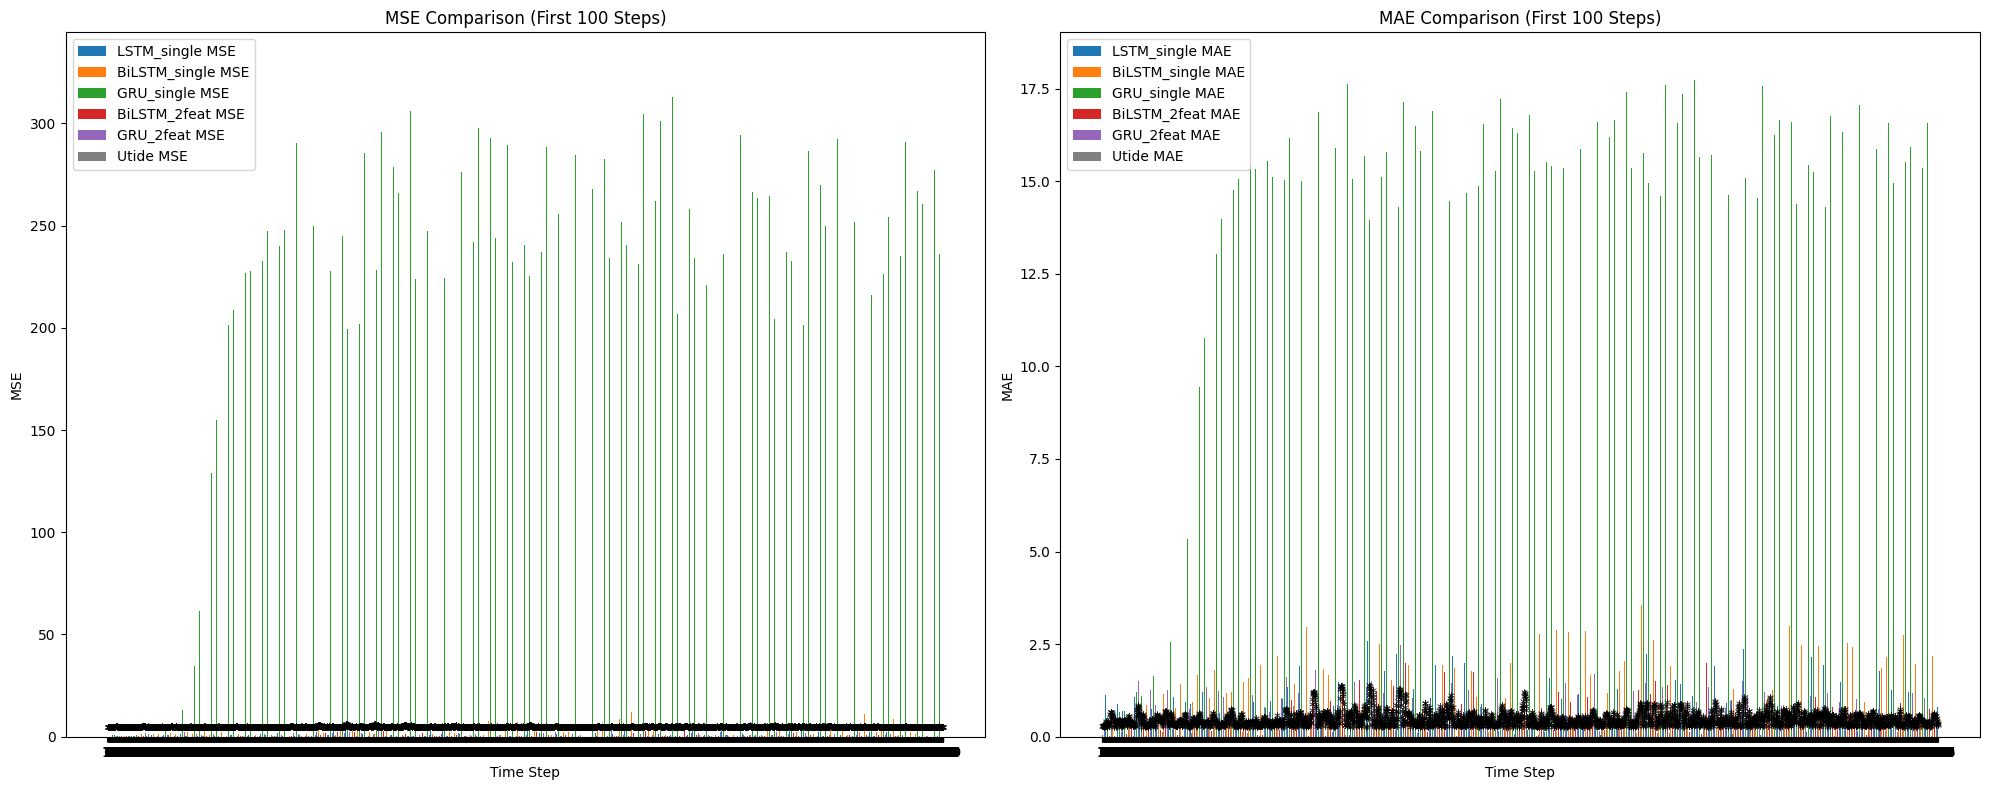

LSTM_single R² falls below Utide at step: 20
BiLSTM_single R² falls below Utide at step: 20
GRU_single R² falls below Utide at step: 20
BiLSTM_2feat R² falls below Utide at step: 20
GRU_2feat R² falls below Utide at step: 20


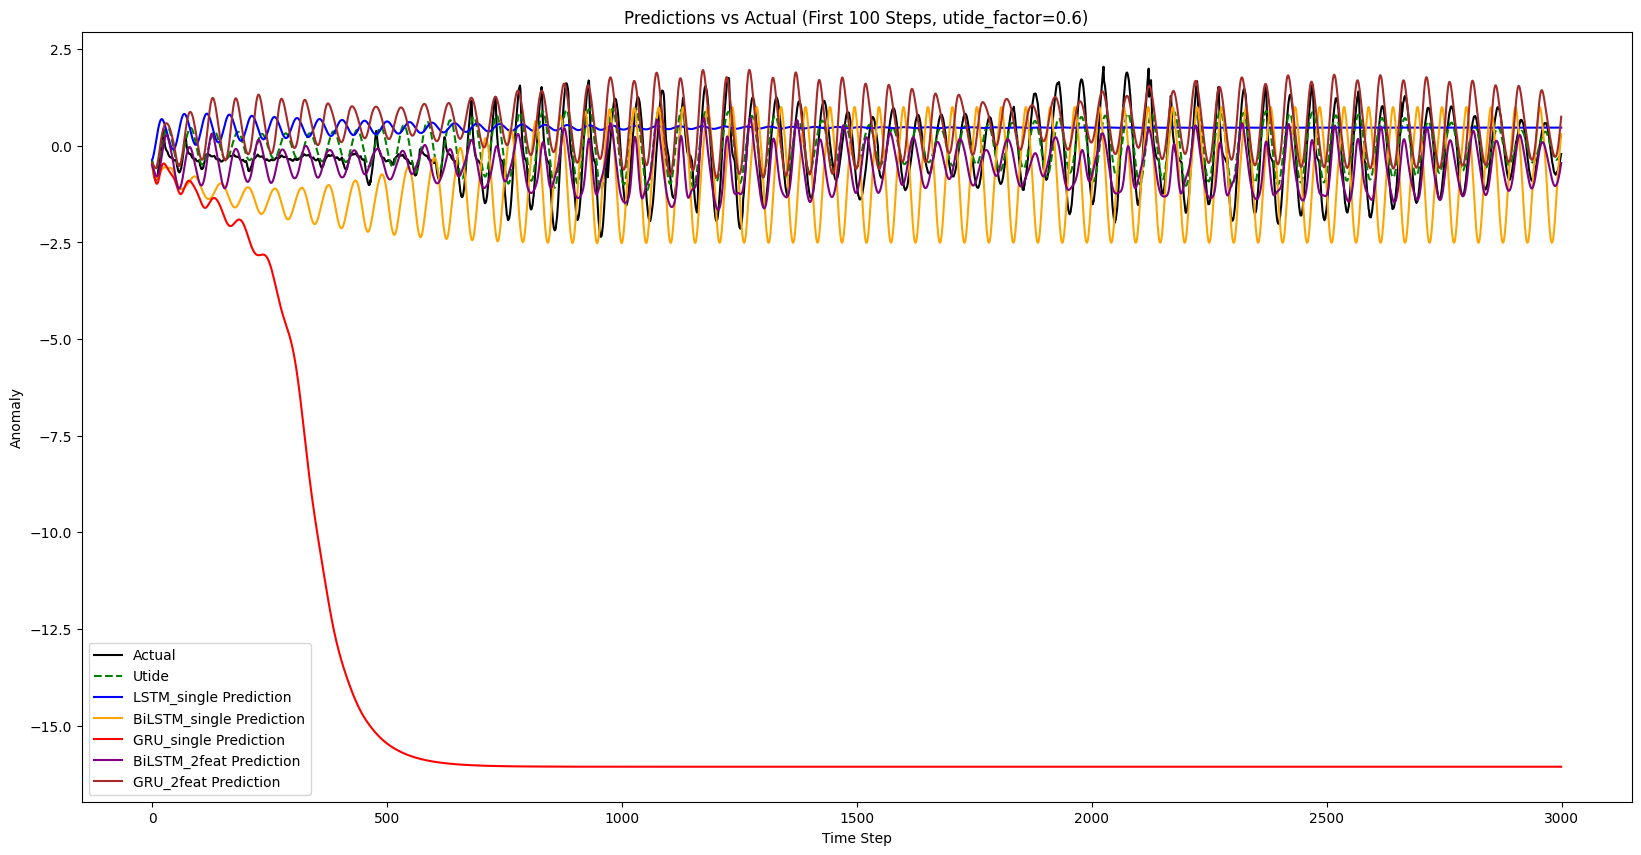

In [ ]:
steps_to_plot = 3000
x = np.arange(steps_to_plot)
model_names = list(results.keys())
width = 0.1

mse_dict = {}
mae_dict = {}

for name in model_names:
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = results[name]['predicted_values'][:steps_to_plot]
    mse = (actual - predicted)**2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

mse_utide = (actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])**2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])

fig, axes = plt.subplots(1,2, figsize=(20,8))

for idx, name in enumerate(model_names):
    axes[0].bar(x + idx*width, mse_dict[name], width, label=f'{name} MSE')
axes[0].bar(x + len(model_names)*width, mse_utide, width, label='Utide MSE', color='grey')
axes[0].set_title('MSE Comparison (First 100 Steps)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mse_dict[m][i] for m in model_names] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    axes[0].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

for idx, name in enumerate(model_names):
    axes[1].bar(x + idx*width, mae_dict[name], width, label=f'{name} MAE')
axes[1].bar(x + len(model_names)*width, mae_utide, width, label='Utide MAE', color='grey')
axes[1].set_title('MAE Comparison (First 100 Steps)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mae_dict[m][i] for m in model_names] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    axes[1].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

for name in model_names:
    model_r2 = results[name]['r2_scores'][indices]
    falloff_indices = np.where(model_r2 < r2_utide)[0]
    first_falloff = falloff_indices[0] if falloff_indices.size > 0 else "Never"
    print(f"{name} R² falls below Utide at step: {first_falloff}")

plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')

colors = ['blue', 'orange', 'red', 'purple', 'brown']
for idx, name in enumerate(model_names):
    predicted = results[name]['predicted_values'][:steps_to_plot]
    plt.plot(predicted, label=f'{name} Prediction', color=colors[idx % len(colors)])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title(f'Predictions vs Actual (First 100 Steps, utide_factor={utide_factor})')
plt.legend()
plt.show()

Selected start index: 15795
Single-feature TrainX: (9900, 100, 1) TrainY: (9900, 1)
Single-feature TestX: (2000, 100, 1) TestY: (2000, 1)
Multi-feature TrainX: (9900, 100, 2) TrainY: (9900,)
Multi-feature TestX: (2000, 100, 2) TestY: (2000,)
Training LSTM_single (utide_factor=0.6)...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.1603 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0456 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0279 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0213 - val_loss: 0.0177 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0185 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0166 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - l

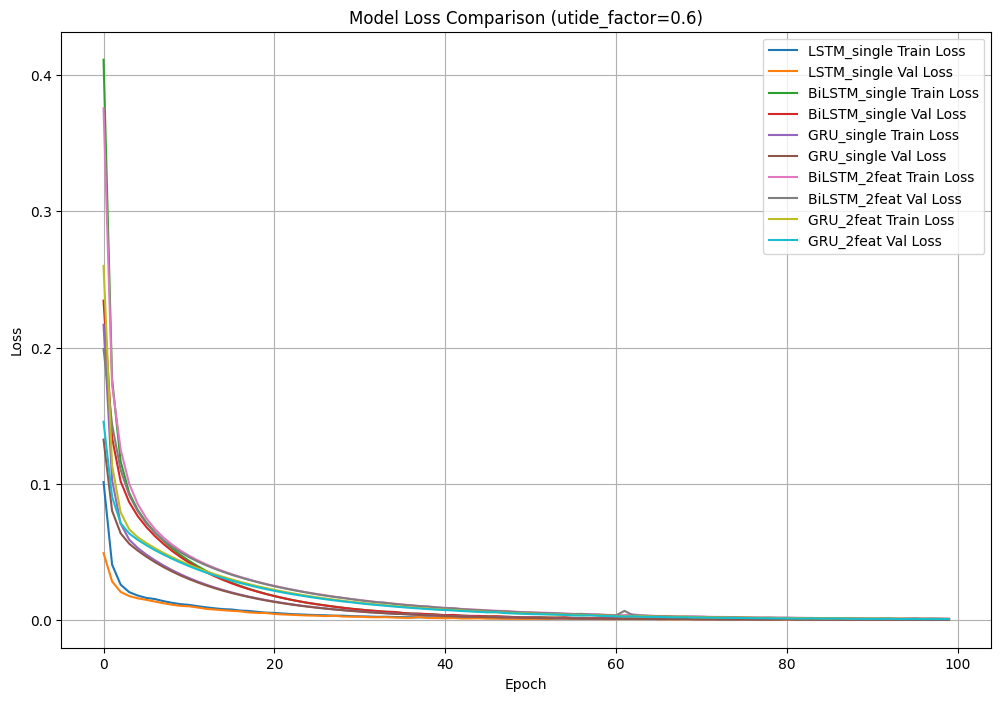

Performing rolling prediction with LSTM_single...
LSTM_single rolling prediction completed.

Performing rolling prediction with BiLSTM_single...
BiLSTM_single rolling prediction completed.

Performing rolling prediction with GRU_single...
GRU_single rolling prediction completed.

Performing rolling prediction with BiLSTM_2feat...
BiLSTM_2feat rolling prediction completed.

Performing rolling prediction with GRU_2feat...
GRU_2feat rolling prediction completed.



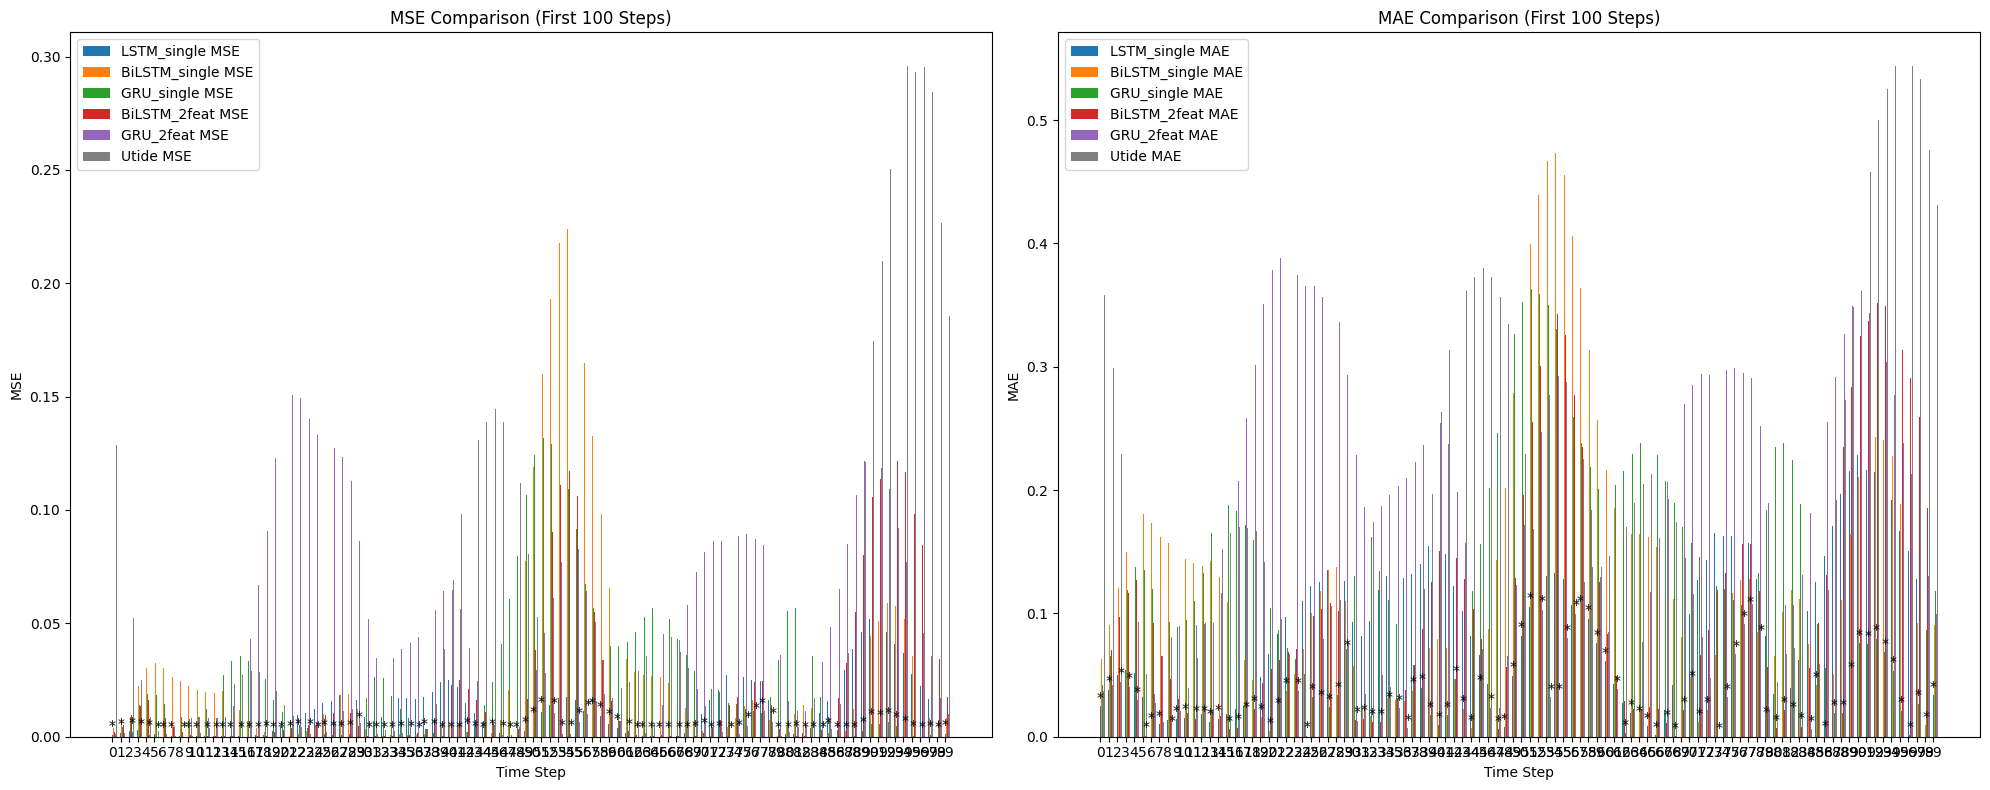

LSTM_single R² falls below Utide at step: 297
BiLSTM_single R² falls below Utide at step: 203
GRU_single R² falls below Utide at step: 248
BiLSTM_2feat R² falls below Utide at step: Never
GRU_2feat R² falls below Utide at step: 23


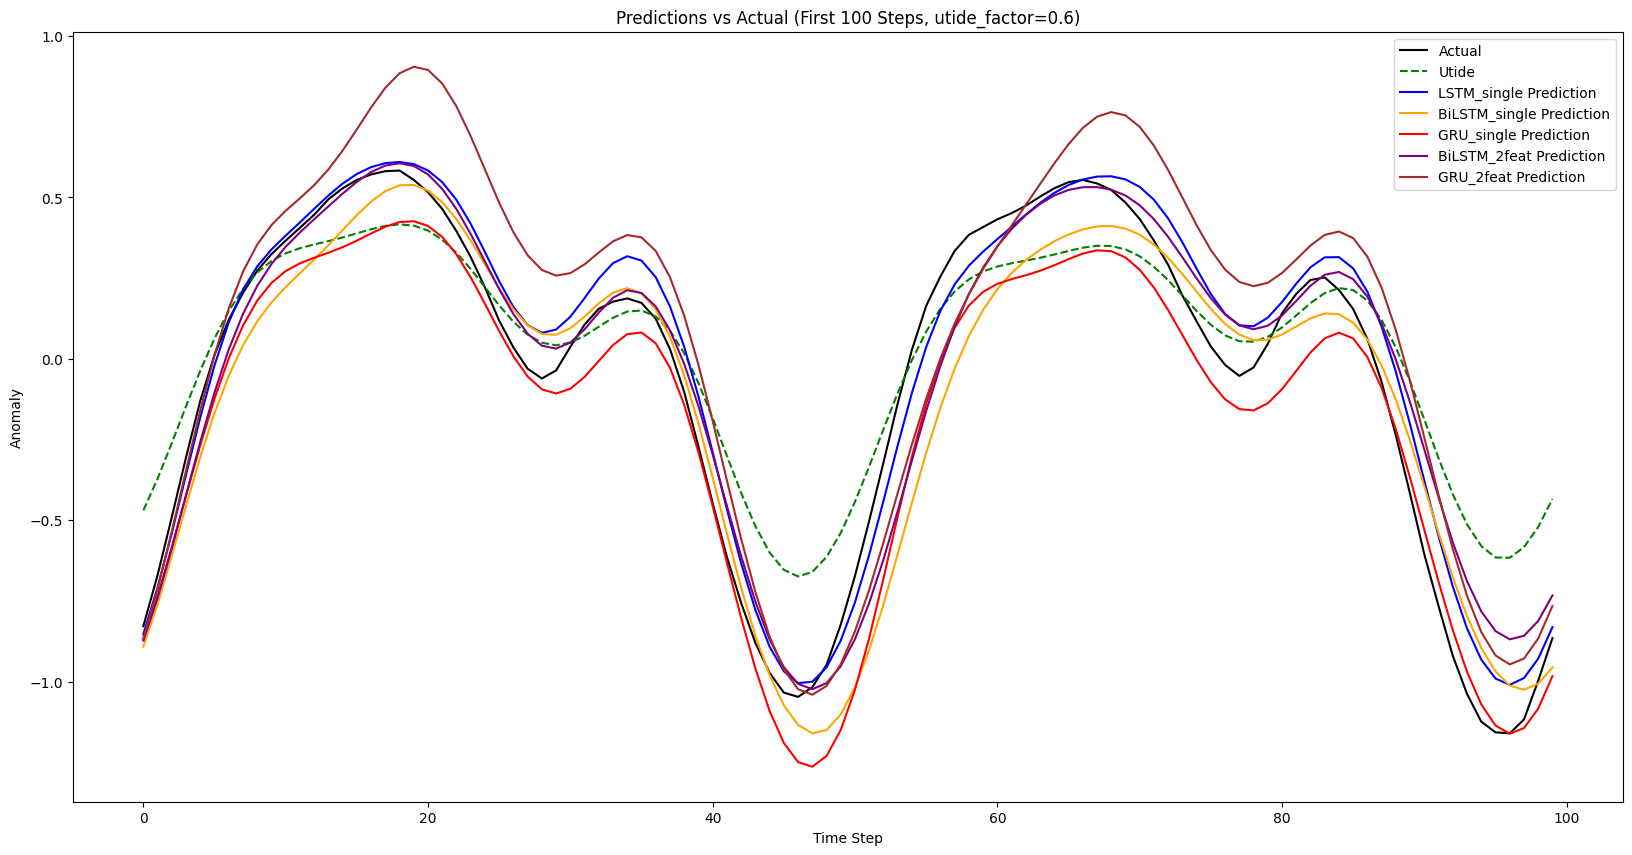

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Model
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, Input, Conv1D, MaxPooling1D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

input_file = "dataProcessed/BOU3Y1_HA_processed.csv"
df = pd.read_csv(input_file, delimiter=',')
total_train_points = 10000
look_back_points = 100
total_test_points = 2000

total_required = total_train_points + look_back_points + total_test_points
if len(df) < total_required:
    raise ValueError(f"Dataset too small. Required: {total_required}, Current: {len(df)}")

max_start_index = len(df) - total_required
start_index = np.random.randint(0, max_start_index + 1)
print(f"Selected start index: {start_index}")

df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)

anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide_original = df_sampled['tide_h'].values.reshape(-1, 1)

utide_factor = 0.6
utide = utide_original * utide_factor

scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))
utide_scaled = scaler_utide.fit_transform(utide)

#（仅 anomaly）
dataset_scaled_single = anomaly_scaled
train_single = dataset_scaled_single[:total_train_points]
test_single = dataset_scaled_single[total_train_points : total_train_points + total_test_points + look_back_points]

#（anomaly + utide）
dataset_scaled_multi = np.hstack((anomaly_scaled, utide_scaled))
train_multi = dataset_scaled_multi[:total_train_points]
test_multi = dataset_scaled_multi[total_train_points : total_train_points + total_test_points + look_back_points]

def create_dataset_single(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

def create_dataset_multi(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX_single, trainY_single = create_dataset_single(train_single, look_back_points)
testX_single, testY_single = create_dataset_single(test_single, look_back_points)

trainX_multi, trainY_multi = create_dataset_multi(train_multi, look_back_points)
testX_multi, testY_multi = create_dataset_multi(test_multi, look_back_points)

print("Single-feature TrainX:", trainX_single.shape, "TrainY:", trainY_single.shape)
print("Single-feature TestX:", testX_single.shape, "TestY:", testY_single.shape)
print("Multi-feature TrainX:", trainX_multi.shape, "TrainY:", trainY_multi.shape)
print("Multi-feature TestX:", testX_multi.shape, "TestY:", testY_multi.shape)

num_features_single = 1
num_features_multi = 2

#model
def build_lstm_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(500, return_sequences=True, kernel_regularizer=l2(0.0001))(input_layer)
    x = Dropout(0.3)(x)
    x = LSTM(500, kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_bilstm_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(700, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(700, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_gru_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(450, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(450, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_bilstm_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(500, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(500, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_gru_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(450, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.4)(x)
    x = Bidirectional(GRU(450, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

#rolling
def rolling_prediction_single_fixed(model, test_multi, scaler_anomaly, scaler_utide, look_back):
    total_tp = len(test_multi) - look_back
    current_input = test_multi[:look_back,0].reshape(-1,1)
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 1)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0,0]
        predicted_anomaly = scaler_anomaly.inverse_transform([[predicted_anomaly_scaled]])[0,0]

        rolling_predictions.append(predicted_anomaly)

        actual_anomaly_scaled = test_multi[look_back + i, 0]
        actual_anomaly = scaler_anomaly.inverse_transform([[actual_anomaly_scaled]])[0, 0]
        actual_values.append(actual_anomaly)

        utide_scaled_val = test_multi[look_back + i, 1]
        utide_val = scaler_utide.inverse_transform([[utide_scaled_val]])[0, 0]
        utide_values.append(utide_val)

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1,0] = predicted_anomaly_scaled

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

def rolling_prediction_multi(model, test, scaler_anomaly, scaler_utide, look_back):
    total_tp = len(test) - look_back
    current_input = test[:look_back].copy()
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 2)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0, 0]

        actual_anomaly_scaled = test[look_back + i, 0]
        actual_anomaly = scaler_anomaly.inverse_transform([[actual_anomaly_scaled]])[0, 0]
        actual_values.append(actual_anomaly)

        utide_scaled_val = test[look_back + i, 1]
        utide_val = scaler_utide.inverse_transform([[utide_scaled_val]])[0, 0]
        utide_values.append(utide_val)

        predicted_anomaly = scaler_anomaly.inverse_transform([[predicted_anomaly_scaled]])[0,0]
        rolling_predictions.append(predicted_anomaly)

        current_input = np.roll(current_input, -1, axis=0)
        if i < total_tp - 1:
            next_utide_scaled = test[look_back + i + 1, 1]
        else:
            next_utide_scaled = test[look_back + i, 1]

        current_input[-1, 0] = predicted_anomaly_scaled
        current_input[-1, 1] = next_utide_scaled

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

single_feature_models = {
    'LSTM_single': build_lstm_single((look_back_points, num_features_single)),
    'BiLSTM_single': build_bilstm_single((look_back_points, num_features_single)),
    'GRU_single': build_gru_single((look_back_points, num_features_single))
}

multi_feature_models = {
    'BiLSTM_2feat': build_bilstm_multi((look_back_points, num_features_multi)),
    'GRU_2feat': build_gru_multi((look_back_points, num_features_multi))
}

all_models = {}
all_models.update(single_feature_models)
all_models.update(multi_feature_models)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

epochs = 100
batch_size = 512

histories = {}

for name, model in all_models.items():
    print(f"Training {name} (utide_factor={utide_factor})...")
    if '2feat' in name:
        history = model.fit(trainX_multi, trainY_multi,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[reduce_lr])
    else:
        history = model.fit(trainX_single, trainY_single,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[reduce_lr])
    histories[name] = history
    print(f"{name} training completed.\n")

plt.figure(figsize=(12,8))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
plt.title(f'Model Loss Comparison (utide_factor={utide_factor})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

results = {}
for name, model in all_models.items():
    print(f"Performing rolling prediction with {name}...")
    if '2feat' in name:
        res = rolling_prediction_multi(model, test_multi, scaler_anomaly, scaler_utide, look_back_points)
    else:
        res = rolling_prediction_single_fixed(model, test_multi, scaler_anomaly, scaler_utide, look_back_points)
    results[name] = res
    print(f"{name} rolling prediction completed.\n")

actual_values_full = scaler_anomaly.inverse_transform(test_multi[look_back_points:look_back_points + total_test_points, 0].reshape(-1,1)).flatten()
utide_values_full = scaler_utide.inverse_transform(test_multi[look_back_points:look_back_points + total_test_points, 1].reshape(-1,1)).flatten()
r2_utide = r2_score(actual_values_full, utide_values_full)

steps_to_plot = 100
x = np.arange(steps_to_plot)
model_names = list(results.keys())
width = 0.1

mse_dict = {}
mae_dict = {}

for name in model_names:
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = results[name]['predicted_values'][:steps_to_plot]
    mse = (actual - predicted)**2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

mse_utide = (actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])**2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])

fig, axes = plt.subplots(1,2, figsize=(20,8))

for idx, name in enumerate(model_names):
    axes[0].bar(x + idx*width, mse_dict[name], width, label=f'{name} MSE')
axes[0].bar(x + len(model_names)*width, mse_utide, width, label='Utide MSE', color='grey')
axes[0].set_title('MSE Comparison (First 100 Steps)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mse_dict[m][i] for m in model_names] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    axes[0].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

for idx, name in enumerate(model_names):
    axes[1].bar(x + idx*width, mae_dict[name], width, label=f'{name} MAE')
axes[1].bar(x + len(model_names)*width, mae_utide, width, label='Utide MAE', color='grey')
axes[1].set_title('MAE Comparison (First 100 Steps)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mae_dict[m][i] for m in model_names] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    axes[1].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

for name in model_names:
    model_r2 = results[name]['r2_scores'][indices]
    falloff_indices = np.where(model_r2 < r2_utide)[0]
    first_falloff = falloff_indices[0] if falloff_indices.size > 0 else "Never"
    print(f"{name} R² falls below Utide at step: {first_falloff}")

plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')

colors = ['blue', 'orange', 'red', 'purple', 'brown']
for idx, name in enumerate(model_names):
    predicted = results[name]['predicted_values'][:steps_to_plot]
    plt.plot(predicted, label=f'{name} Prediction', color=colors[idx % len(colors)])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title(f'Predictions vs Actual (First 100 Steps, utide_factor={utide_factor})')
plt.legend()
plt.show()

Selected start index: 112727
Single-feature TrainX: (9900, 100, 1) TrainY: (9900, 1)
Single-feature TestX: (2000, 100, 1) TestY: (2000, 1)
Multi-feature TrainX: (9900, 100, 2) TrainY: (9900,)
Multi-feature TestX: (2000, 100, 2) TestY: (2000,)
Training LSTM_single (utide_factor=0.4)...
Epoch 1/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.1450 - val_loss: 0.0455 - learning_rate: 0.0010
Epoch 2/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0400 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 3/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0241 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 4/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0186 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 5/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0164 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 6/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0148 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 7/80
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0

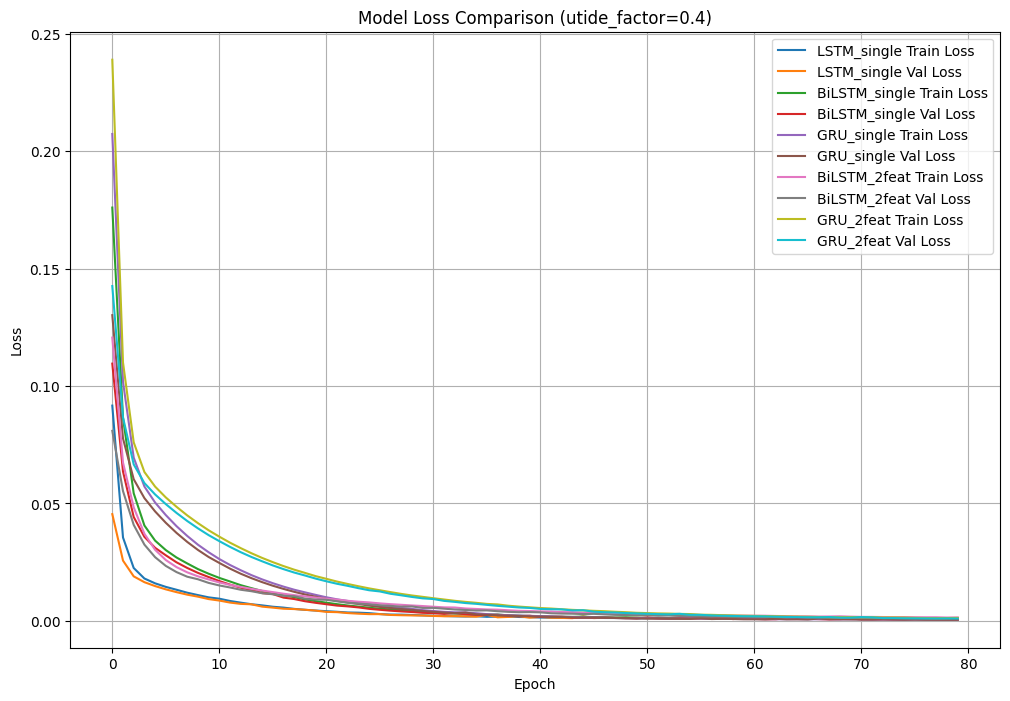

Performing rolling prediction with LSTM_single...
LSTM_single rolling prediction completed.

Performing rolling prediction with BiLSTM_single...
BiLSTM_single rolling prediction completed.

Performing rolling prediction with GRU_single...
GRU_single rolling prediction completed.

Performing rolling prediction with BiLSTM_2feat...
BiLSTM_2feat rolling prediction completed.

Performing rolling prediction with GRU_2feat...
GRU_2feat rolling prediction completed.



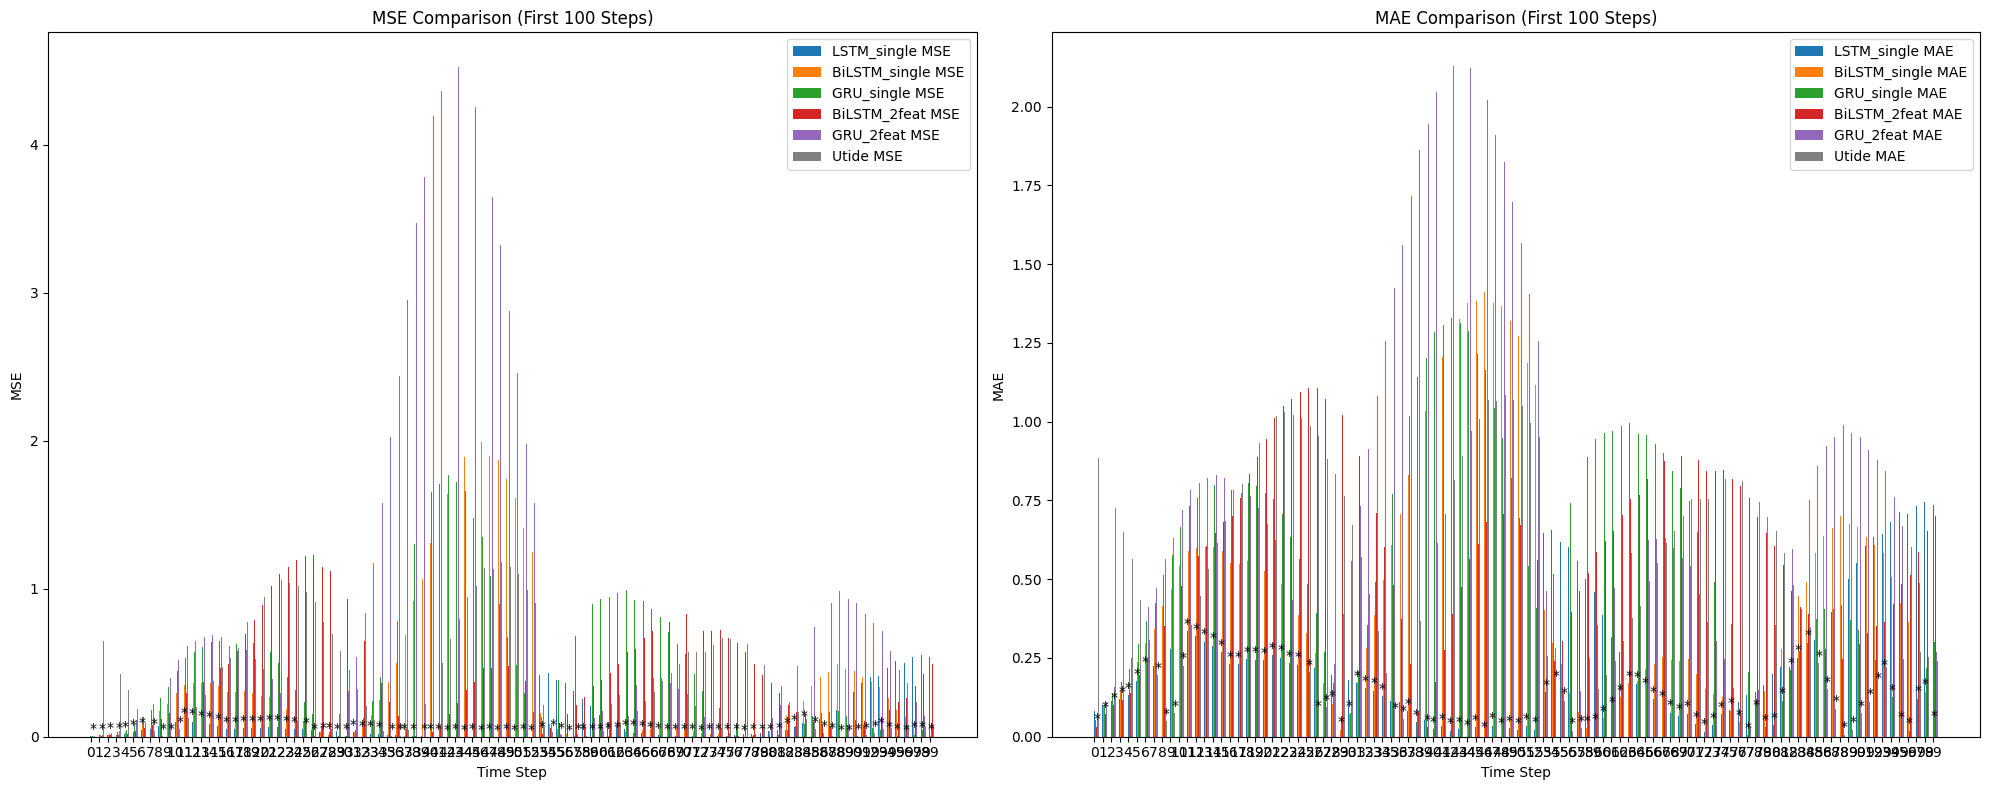

LSTM_single R² falls below Utide at step: Never
BiLSTM_single R² falls below Utide at step: 49
GRU_single R² falls below Utide at step: 38
BiLSTM_2feat R² falls below Utide at step: 26
GRU_2feat R² falls below Utide at step: 34


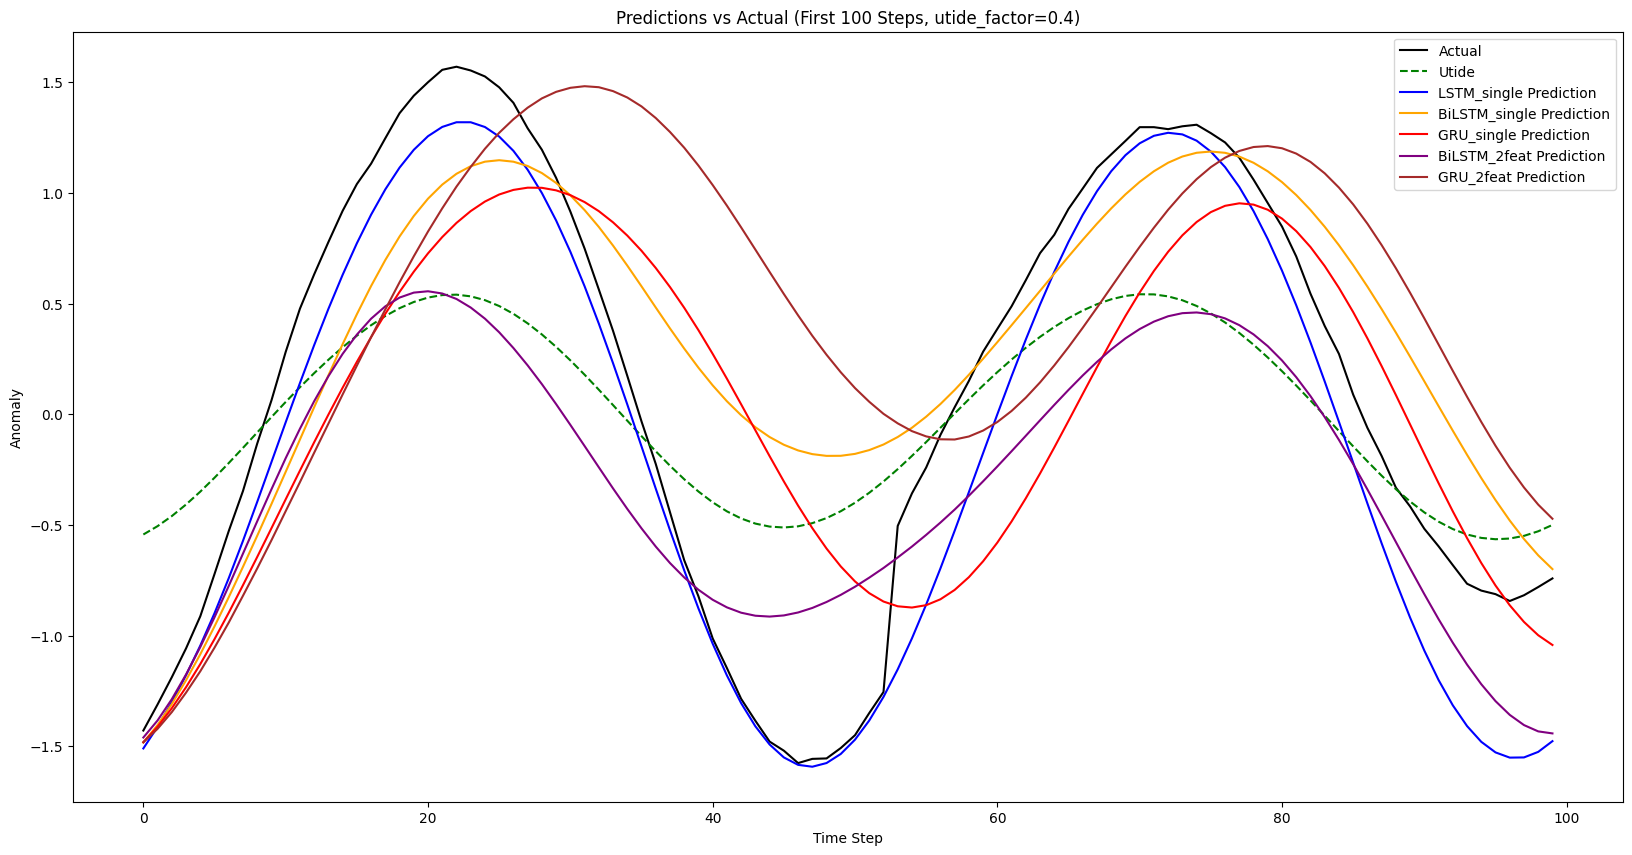

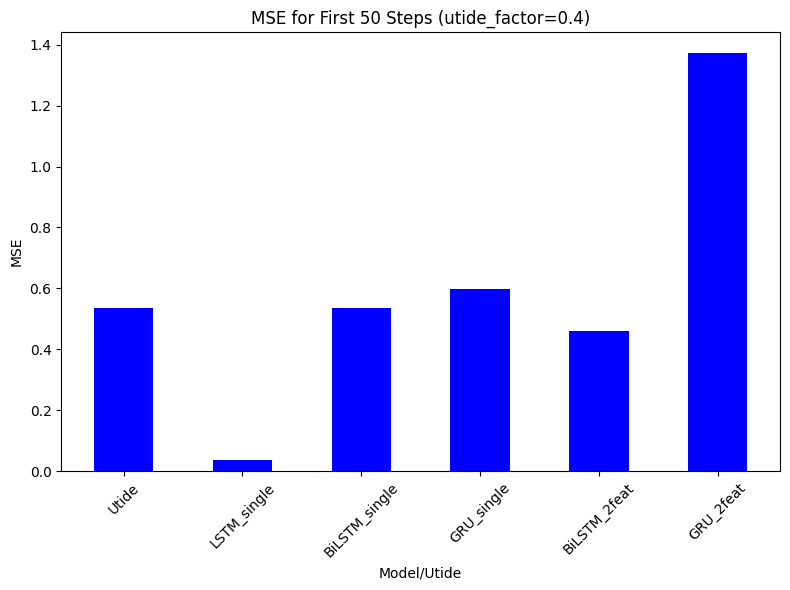

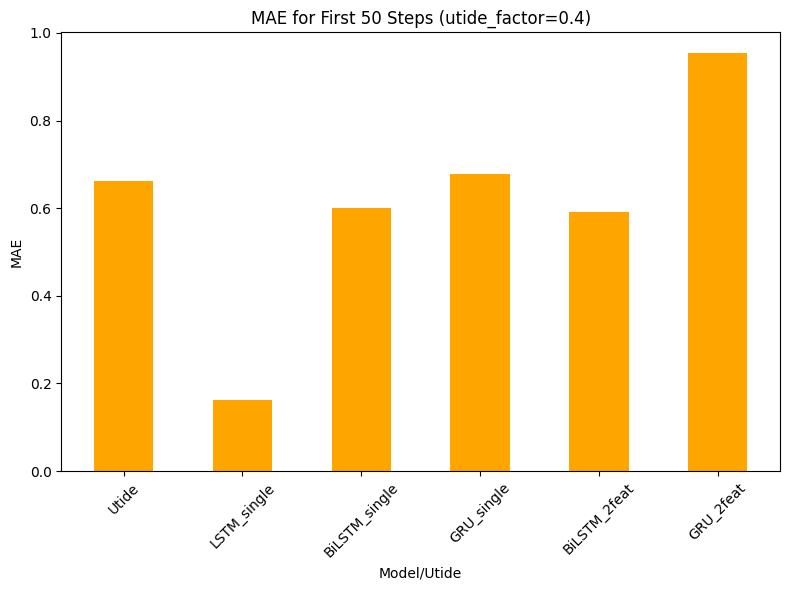

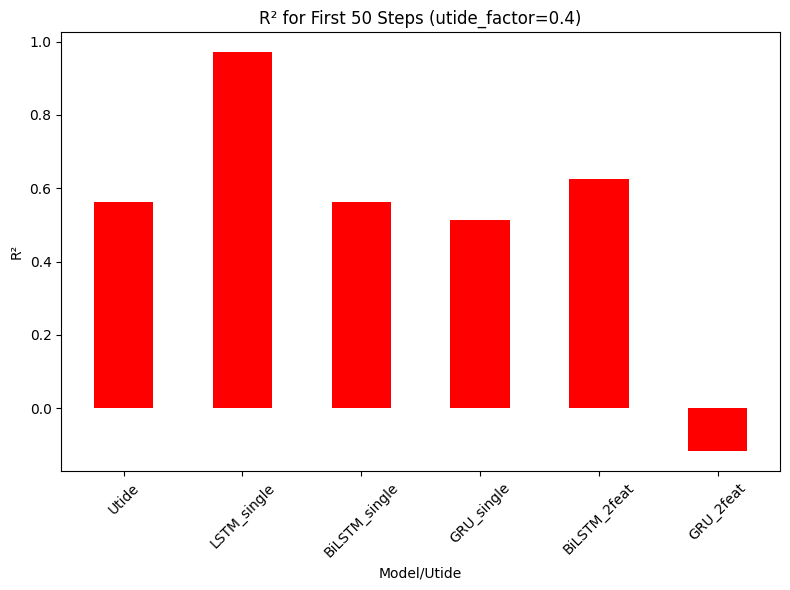

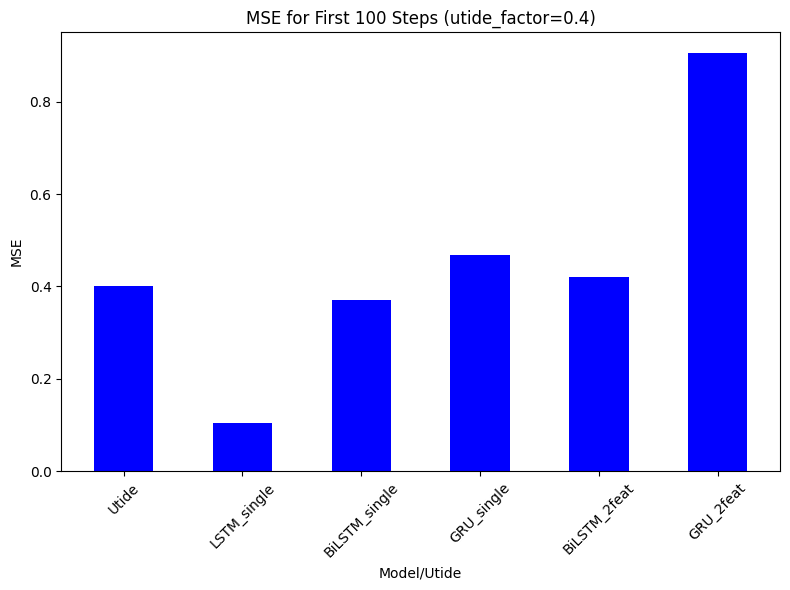

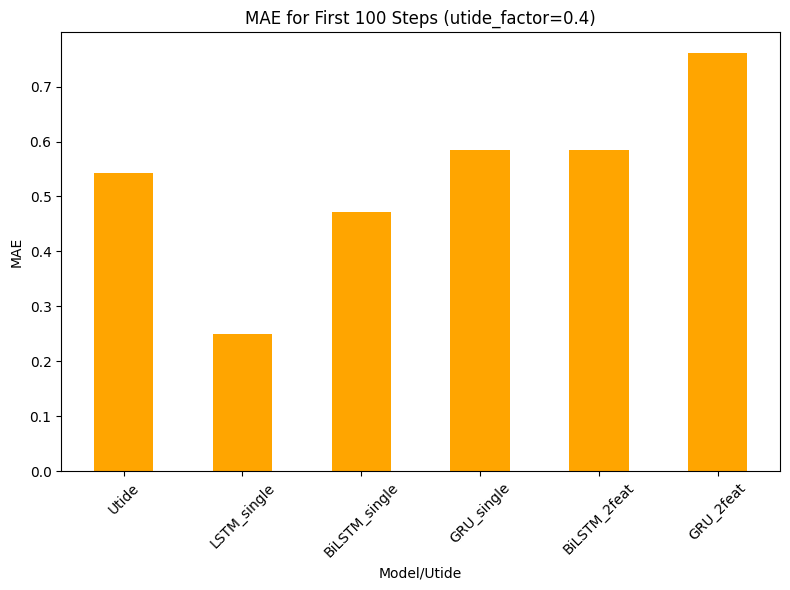

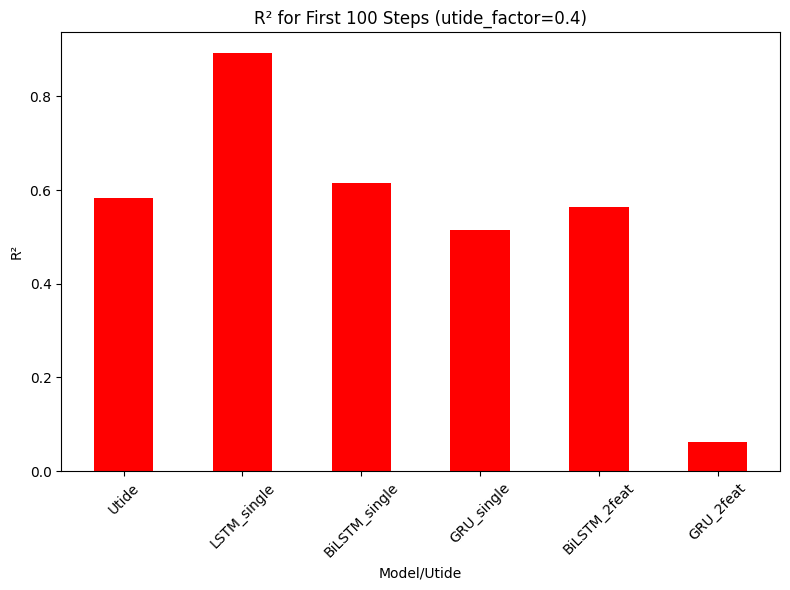

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Model
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, Input, Conv1D, MaxPooling1D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import tensorflow as tf


# np.random.seed(42)
# tf.random.set_seed(42)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = pd.read_csv(input_file, delimiter=',')
total_train_points = 10000
look_back_points = 100
total_test_points = 2000

total_required = total_train_points + look_back_points + total_test_points
if len(df) < total_required:
    raise ValueError(f"Dataset too small. Required: {total_required}, Current: {len(df)}")

max_start_index = len(df) - total_required
start_index = np.random.randint(0, max_start_index + 1)
print(f"Selected start index: {start_index}")

df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)

anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide_original = df_sampled['utide'].values.reshape(-1, 1)


utide_factor = 0.4
utide = utide_original * utide_factor

data = np.hstack((anomaly, utide))
scaler_all = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_all.fit_transform(data)

anomaly_scaled = data_scaled[:,0:1]
utide_scaled = data_scaled[:,1:2]

#（仅 anomaly）
dataset_scaled_single = anomaly_scaled
train_single = dataset_scaled_single[:total_train_points]
test_single = dataset_scaled_single[total_train_points : total_train_points + total_test_points + look_back_points]

#（anomaly + utide）
dataset_scaled_multi = data_scaled
train_multi = dataset_scaled_multi[:total_train_points]
test_multi = dataset_scaled_multi[total_train_points : total_train_points + total_test_points + look_back_points]

def create_dataset_single(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

def create_dataset_multi(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX_single, trainY_single = create_dataset_single(train_single, look_back_points)
testX_single, testY_single = create_dataset_single(test_single, look_back_points)

trainX_multi, trainY_multi = create_dataset_multi(train_multi, look_back_points)
testX_multi, testY_multi = create_dataset_multi(test_multi, look_back_points)

print("Single-feature TrainX:", trainX_single.shape, "TrainY:", trainY_single.shape)
print("Single-feature TestX:", testX_single.shape, "TestY:", testY_single.shape)
print("Multi-feature TrainX:", trainX_multi.shape, "TrainY:", trainY_multi.shape)
print("Multi-feature TestX:", testX_multi.shape, "TestY:", testY_multi.shape)

num_features_single = 1
num_features_multi = 2

def inverse_anomaly(value_scaled):
    temp = np.zeros((1,2))
    temp[0,0] = value_scaled
    original = scaler_all.inverse_transform(temp)
    return original[0,0]

def inverse_utide(value_scaled):
    temp = np.zeros((1,2))
    temp[0,1] = value_scaled
    original = scaler_all.inverse_transform(temp)
    return original[0,1]

def inverse_array_anomaly(arr_scaled):
    temp = np.zeros((len(arr_scaled), 2))
    temp[:,0] = arr_scaled
    original = scaler_all.inverse_transform(temp)
    return original[:,0]

def inverse_array_utide(arr_scaled):
    temp = np.zeros((len(arr_scaled), 2))
    temp[:,1] = arr_scaled
    original = scaler_all.inverse_transform(temp)
    return original[:,1]


#model
def build_lstm_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(500, return_sequences=True, kernel_regularizer=l2(0.0001))(input_layer)
    x = Dropout(0.3)(x)
    x = LSTM(500, kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_bilstm_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(500, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(200, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_gru_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(450, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(450, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_bilstm_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(300, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(100, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_gru_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(450, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.4)(x)
    x = Bidirectional(GRU(450, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

#rolling
def rolling_prediction_single_fixed(model, test_multi, scaler_all, look_back):
    total_tp = len(test_multi) - look_back
    current_input = test_multi[:look_back,0].reshape(-1,1) # single feature
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 1)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0,0]
        predicted_anomaly = inverse_anomaly(predicted_anomaly_scaled)

        rolling_predictions.append(predicted_anomaly)

        actual_anomaly_scaled = test_multi[look_back + i, 0]
        actual_anomaly = inverse_anomaly(actual_anomaly_scaled)
        actual_values.append(actual_anomaly)

        utide_scaled_val = test_multi[look_back + i, 1]
        utide_val = inverse_utide(utide_scaled_val)
        utide_values.append(utide_val)

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            r2_scores_utide = r2_score(actual_values, utide_values)
            utide_r2_scores.append(r2_scores_utide)
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)


        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1,0] = predicted_anomaly_scaled

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

def rolling_prediction_multi(model, test, scaler_all, look_back):
    total_tp = len(test) - look_back
    current_input = test[:look_back].copy()
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 2)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0, 0]
        predicted_anomaly = inverse_anomaly(predicted_anomaly_scaled)

        actual_anomaly_scaled = test[look_back + i, 0]
        actual_anomaly = inverse_anomaly(actual_anomaly_scaled)
        actual_values.append(actual_anomaly)

        utide_scaled_val = test[look_back + i, 1]
        utide_val = inverse_utide(utide_scaled_val)
        utide_values.append(utide_val)

        rolling_predictions.append(predicted_anomaly)

        current_input = np.roll(current_input, -1, axis=0)
        if i < total_tp - 1:
            next_utide_scaled = test[look_back + i + 1, 1]
        else:
            next_utide_scaled = test[look_back + i, 1]

        current_input[-1, 0] = predicted_anomaly_scaled
        current_input[-1, 1] = next_utide_scaled

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

single_feature_models = {
    'LSTM_single': build_lstm_single((look_back_points, num_features_single)),
    'BiLSTM_single': build_bilstm_single((look_back_points, num_features_single)),
    'GRU_single': build_gru_single((look_back_points, num_features_single))
}

multi_feature_models = {
    'BiLSTM_2feat': build_bilstm_multi((look_back_points, num_features_multi)),
    'GRU_2feat': build_gru_multi((look_back_points, num_features_multi))
}

all_models = {}
all_models.update(single_feature_models)
all_models.update(multi_feature_models)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

epochs = 80
batch_size = 512

histories = {}

for name, model in all_models.items():
    print(f"Training {name} (utide_factor={utide_factor})...")
    if '2feat' in name:
        history = model.fit(trainX_multi, trainY_multi,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[reduce_lr])
    else:
        history = model.fit(trainX_single, trainY_single,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[reduce_lr])
    histories[name] = history
    print(f"{name} training completed.\n")

plt.figure(figsize=(12,8))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
plt.title(f'Model Loss Comparison (utide_factor={utide_factor})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

results = {}
for name, model in all_models.items():
    print(f"Performing rolling prediction with {name}...")
    if '2feat' in name:
        res = rolling_prediction_multi(model, test_multi, scaler_all, look_back_points)
    else:
        res = rolling_prediction_single_fixed(model, test_multi, scaler_all, look_back_points)
    results[name] = res
    print(f"{name} rolling prediction completed.\n")

actual_values_full = inverse_array_anomaly(test_multi[look_back_points:look_back_points + total_test_points, 0])
utide_values_full = inverse_array_utide(test_multi[look_back_points:look_back_points + total_test_points, 1])
r2_utide = r2_score(actual_values_full, utide_values_full)

steps_to_plot = 100
x = np.arange(steps_to_plot)
model_names = list(results.keys())
width = 0.1

mse_dict = {}
mae_dict = {}

for name in model_names:
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = results[name]['predicted_values'][:steps_to_plot]
    mse = (actual - predicted)**2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

mse_utide = (actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])**2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])

fig, axes = plt.subplots(1,2, figsize=(20,8))

for idx, name in enumerate(model_names):
    axes[0].bar(x + idx*width, mse_dict[name], width, label=f'{name} MSE')
axes[0].bar(x + len(model_names)*width, mse_utide, width, label='Utide MSE', color='grey')
axes[0].set_title('MSE Comparison (First 100 Steps)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mse_dict[m][i] for m in model_names] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    axes[0].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

for idx, name in enumerate(model_names):
    axes[1].bar(x + idx*width, mae_dict[name], width, label=f'{name} MAE')
axes[1].bar(x + len(model_names)*width, mae_utide, width, label='Utide MAE', color='grey')
axes[1].set_title('MAE Comparison (First 100 Steps)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mae_dict[m][i] for m in model_names] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    axes[1].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

for name in model_names:
    model_r2 = results[name]['r2_scores'][indices]
    falloff_indices = np.where(model_r2 < r2_utide)[0]
    first_falloff = falloff_indices[0] if falloff_indices.size > 0 else "Never"
    print(f"{name} R² falls below Utide at step: {first_falloff}")

plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')

colors = ['blue', 'orange', 'red', 'purple', 'brown']
for idx, name in enumerate(model_names):
    predicted = results[name]['predicted_values'][:steps_to_plot]
    plt.plot(predicted, label=f'{name} Prediction', color=colors[idx % len(colors)])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title(f'Predictions vs Actual (First 100 Steps, utide_factor={utide_factor})')
plt.legend()
plt.show()

def compute_metrics_for_steps(steps, results, actual_values_full, utide_values_full):
    # Utide
    utide_mse_val = mean_squared_error(actual_values_full[:steps], utide_values_full[:steps])
    utide_mae_val = mean_absolute_error(actual_values_full[:steps], utide_values_full[:steps])
    utide_r2_val = r2_score(actual_values_full[:steps], utide_values_full[:steps])

    mse_vals = [utide_mse_val]
    mae_vals = [utide_mae_val]
    r2_vals = [utide_r2_val]

    for name in model_names:
        actual = results[name]['actual_values'][:steps]
        pred = results[name]['predicted_values'][:steps]
        mse_val = mean_squared_error(actual, pred)
        mae_val = mean_absolute_error(actual, pred)
        r2_val = r2_score(actual, pred)
        mse_vals.append(mse_val)
        mae_vals.append(mae_val)
        r2_vals.append(r2_val)

    labels = ['Utide'] + model_names
    return labels, mse_vals, mae_vals, r2_vals

steps_list = [50, 100]
for steps_ in steps_list:
    labels, mse_vals, mae_vals, r2_vals = compute_metrics_for_steps(steps_, results, actual_values_full, utide_values_full)

    x = np.arange(len(labels))
    width = 0.5

    # MSE
    plt.figure(figsize=(8,6))
    plt.bar(x, mse_vals, width, color='blue')
    plt.title(f'MSE for First {steps_} Steps (utide_factor={utide_factor})')
    plt.xlabel('Model/Utide')
    plt.ylabel('MSE')
    plt.xticks(x, labels, rotation=45)
    plt.tight_layout()
    plt.show()

    # MAE
    plt.figure(figsize=(8,6))
    plt.bar(x, mae_vals, width, color='orange')
    plt.title(f'MAE for First {steps_} Steps (utide_factor={utide_factor})')
    plt.xlabel('Model/Utide')
    plt.ylabel('MAE')
    plt.xticks(x, labels, rotation=45)
    plt.tight_layout()
    plt.show()

    # R2
    plt.figure(figsize=(8,6))
    plt.bar(x, r2_vals, width, color='red')
    plt.title(f'R² for First {steps_} Steps (utide_factor={utide_factor})')
    plt.xlabel('Model/Utide')
    plt.ylabel('R²')
    plt.xticks(x, labels, rotation=45)
    plt.tight_layout()
    plt.show()

Selected start index: 15795
Single-feature TrainX: (9900, 100, 1) TrainY: (9900, 1)
Single-feature TestX: (2000, 100, 1) TestY: (2000, 1)
Multi-feature TrainX: (9900, 100, 2) TrainY: (9900,)
Multi-feature TestX: (2000, 100, 2) TestY: (2000,)
Training LSTM_single...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.2645 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0759 - val_loss: 0.0530 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0549 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0433 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0362 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0317 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0286 - val_l

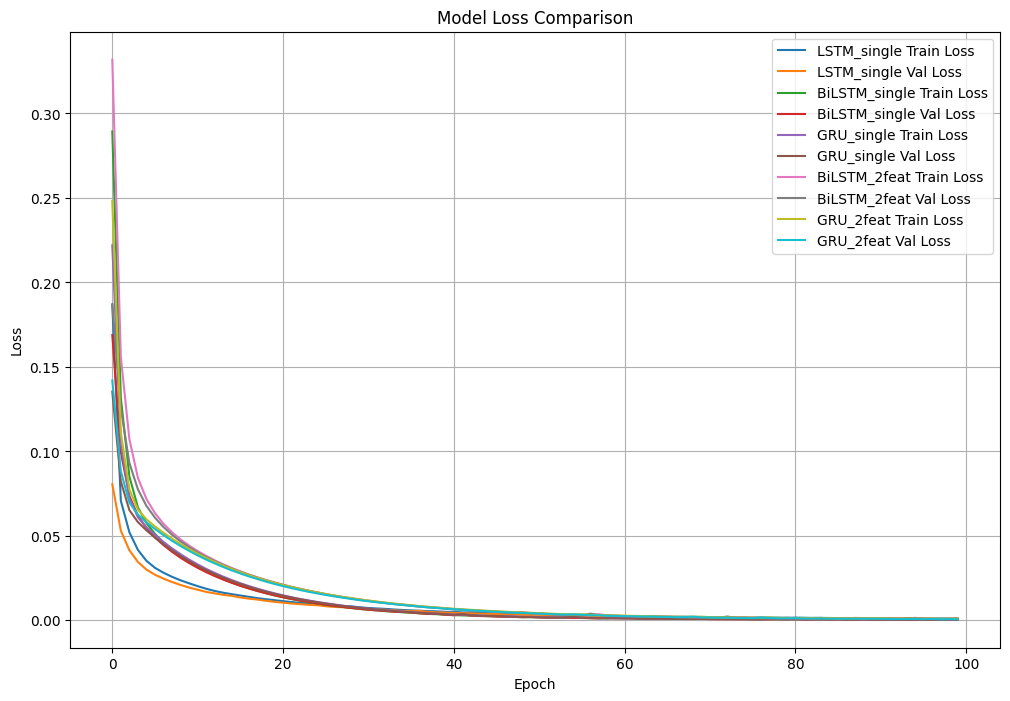

Performing rolling prediction with LSTM_single...
LSTM_single rolling prediction completed.

Performing rolling prediction with BiLSTM_single...
BiLSTM_single rolling prediction completed.

Performing rolling prediction with GRU_single...
GRU_single rolling prediction completed.

Performing rolling prediction with BiLSTM_2feat...
BiLSTM_2feat rolling prediction completed.

Performing rolling prediction with GRU_2feat...
GRU_2feat rolling prediction completed.



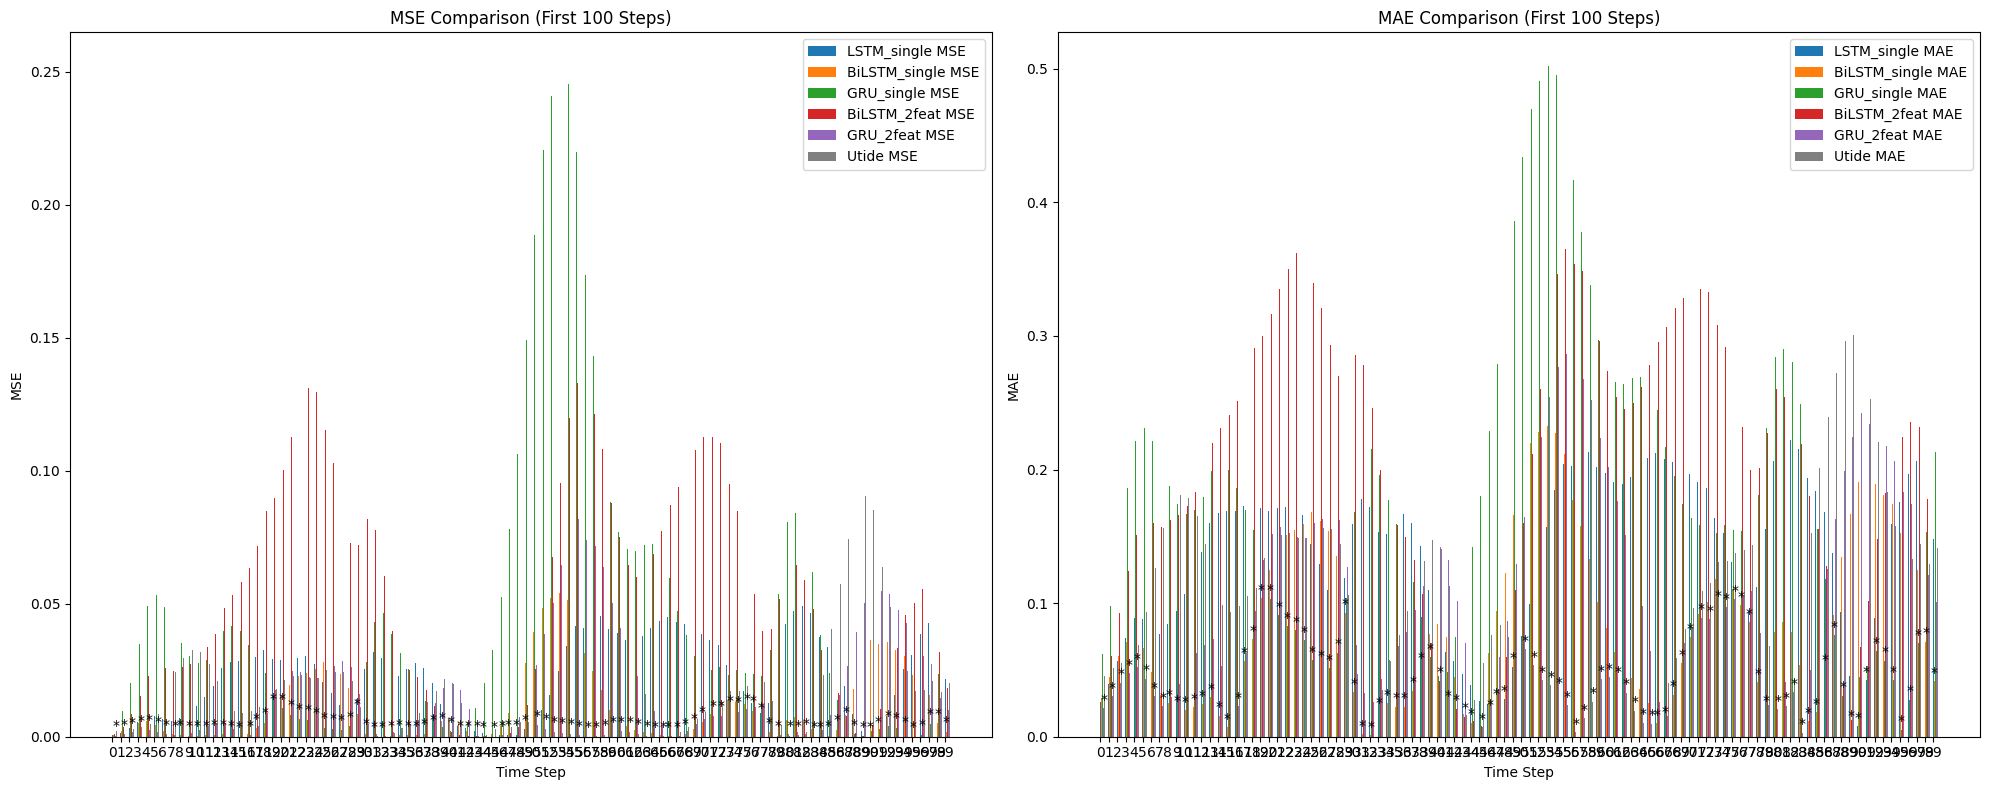

LSTM_single R² falls below Utide at step: 20
BiLSTM_single R² falls below Utide at step: 125
GRU_single R² falls below Utide at step: 20
BiLSTM_2feat R² falls below Utide at step: 20
GRU_2feat R² falls below Utide at step: 122


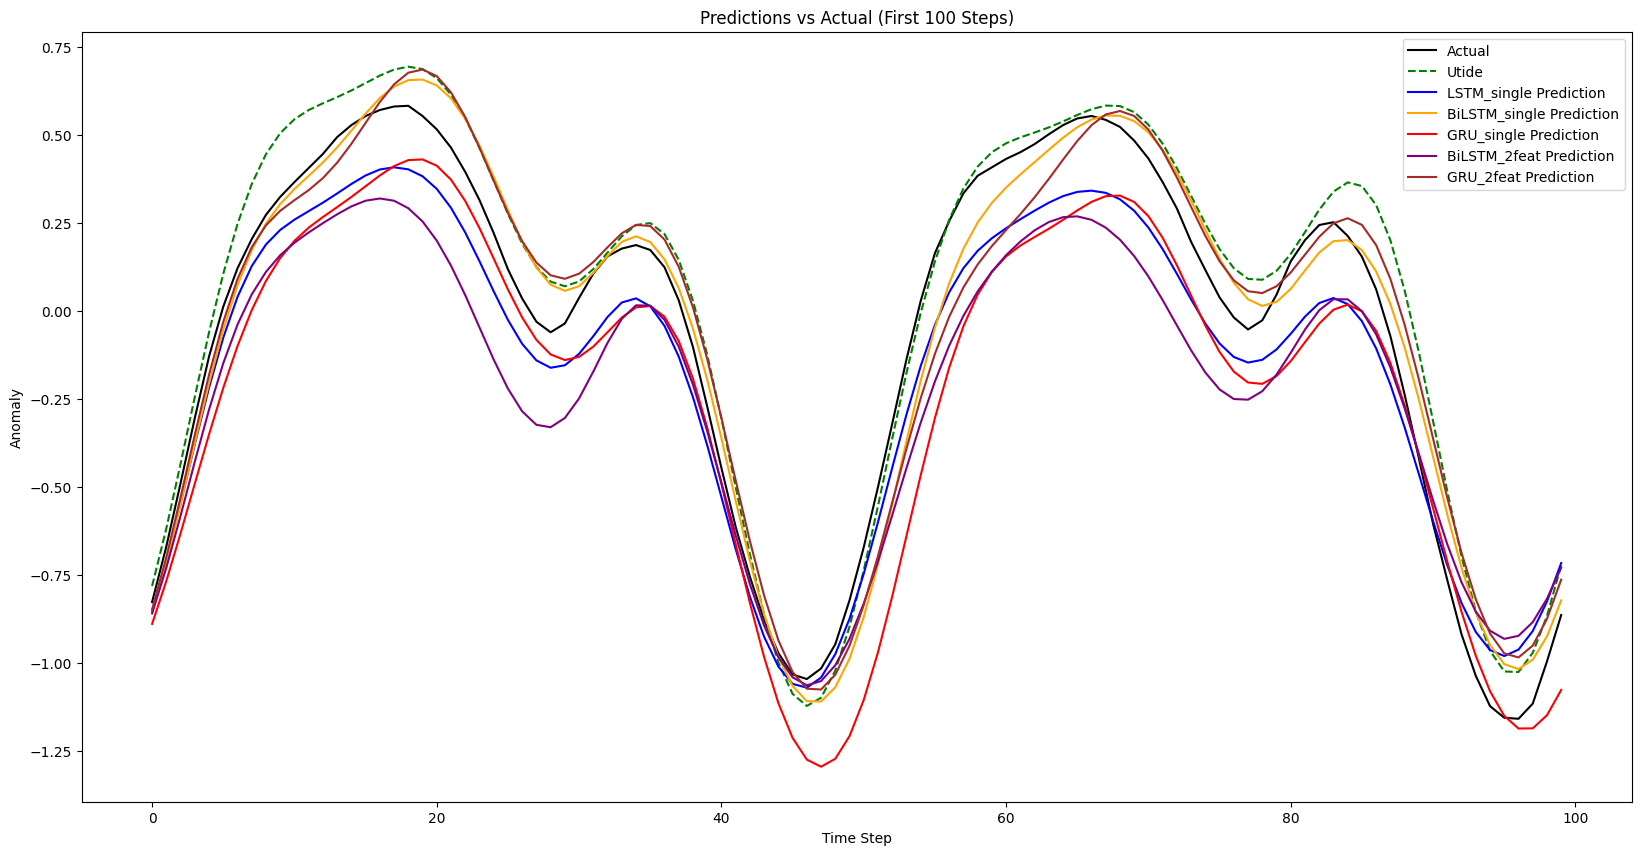

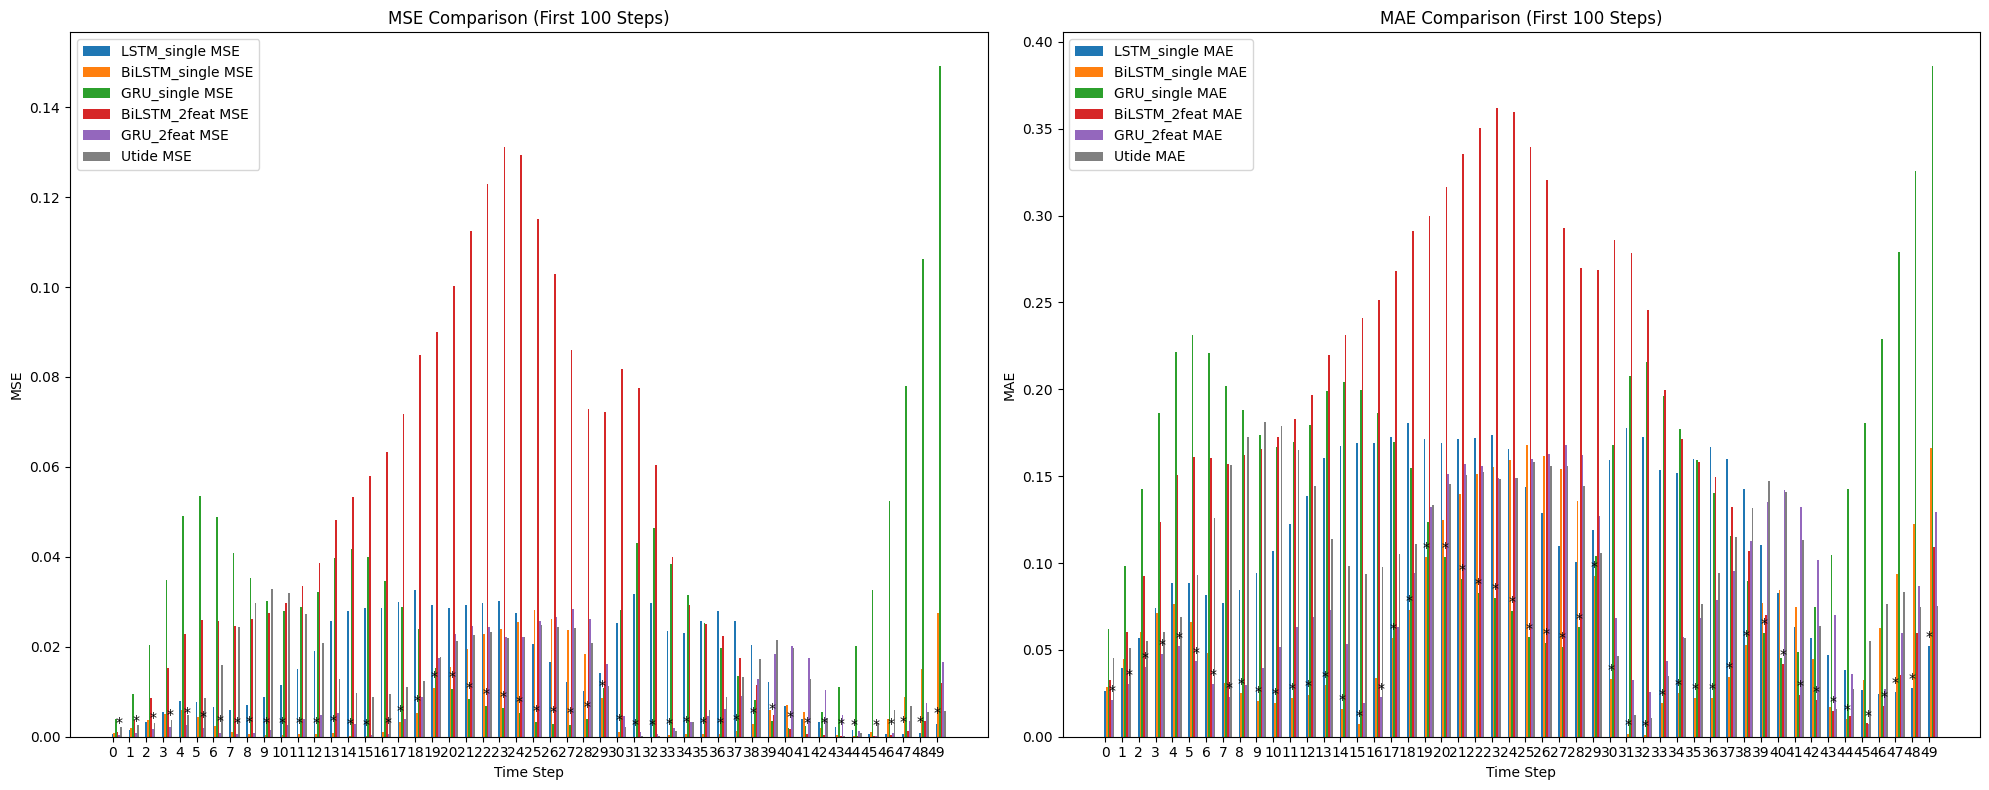

LSTM_single R² falls below Utide at step: 20
BiLSTM_single R² falls below Utide at step: 125
GRU_single R² falls below Utide at step: 20
BiLSTM_2feat R² falls below Utide at step: 20
GRU_2feat R² falls below Utide at step: 122


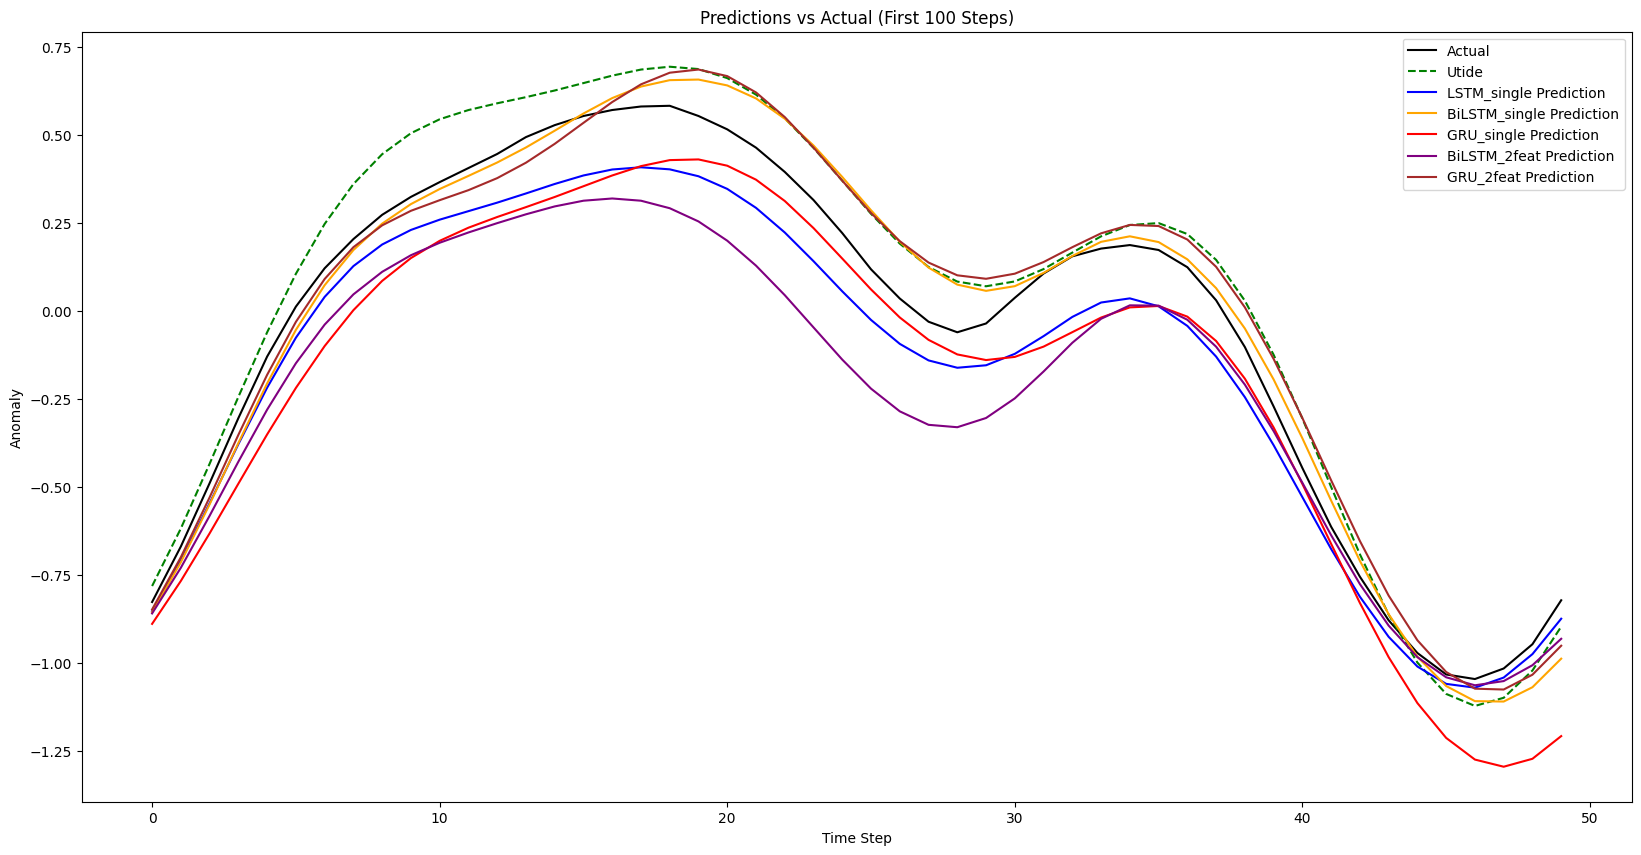

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Model
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, Input, Conv1D, MaxPooling1D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

input_file = "dataProcessed/BOU3Y1_HA_processed.csv"

df = pd.read_csv(input_file, delimiter=',')
total_train_points = 10000
look_back_points = 100
total_test_points = 2000

total_required = total_train_points + look_back_points + total_test_points
if len(df) < total_required:
    raise ValueError(f"Dataset too small. Required: {total_required}, Current: {len(df)}")

max_start_index = len(df) - total_required
start_index = np.random.randint(0, max_start_index + 1)
print(f"Selected start index: {start_index}")

df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)

anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide = df_sampled['tide_h'].values.reshape(-1, 1)

scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))
utide_scaled = scaler_utide.fit_transform(utide)

#（仅anomaly）
dataset_scaled_single = anomaly_scaled
train_single = dataset_scaled_single[:total_train_points]
test_single = dataset_scaled_single[total_train_points : total_train_points + total_test_points + look_back_points]

#（anomaly + utide）
dataset_scaled_multi = np.hstack((anomaly_scaled, utide_scaled))
train_multi = dataset_scaled_multi[:total_train_points]
test_multi = dataset_scaled_multi[total_train_points : total_train_points + total_test_points + look_back_points]

def create_dataset_single(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

def create_dataset_multi(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX_single, trainY_single = create_dataset_single(train_single, look_back_points)
testX_single, testY_single = create_dataset_single(test_single, look_back_points)

trainX_multi, trainY_multi = create_dataset_multi(train_multi, look_back_points)
testX_multi, testY_multi = create_dataset_multi(test_multi, look_back_points)

print("Single-feature TrainX:", trainX_single.shape, "TrainY:", trainY_single.shape)
print("Single-feature TestX:", testX_single.shape, "TestY:", testY_single.shape)
print("Multi-feature TrainX:", trainX_multi.shape, "TrainY:", trainY_multi.shape)
print("Multi-feature TestX:", testX_multi.shape, "TestY:", testY_multi.shape)

num_features_single = 1
num_features_multi = 2
#model
def build_lstm_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(500, return_sequences=True, kernel_regularizer=l2(0.0001))(input_layer)
    x = Dropout(0.3)(x)
    x = LSTM(500, kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_bilstm_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(700, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(700, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_gru_single(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(450, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(450, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_bilstm_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(500, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(500, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def build_gru_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(450, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.4)(x)
    x = Bidirectional(GRU(450, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def rolling_prediction_single_fixed(model, test_multi, scaler_anomaly, scaler_utide, look_back):
    total_tp = len(test_multi) - look_back
    current_input = test_multi[:look_back,0].reshape(-1,1)
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 1)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0,0]
        predicted_anomaly = scaler_anomaly.inverse_transform([[predicted_anomaly_scaled]])[0,0]

        rolling_predictions.append(predicted_anomaly)

        actual_anomaly_scaled = test_multi[look_back + i, 0]
        actual_anomaly = scaler_anomaly.inverse_transform([[actual_anomaly_scaled]])[0, 0]
        actual_values.append(actual_anomaly)

        utide_scaled_val = test_multi[look_back + i, 1]
        utide_val = scaler_utide.inverse_transform([[utide_scaled_val]])[0, 0]
        utide_values.append(utide_val)

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1,0] = predicted_anomaly_scaled

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

def rolling_prediction_multi(model, test, scaler_anomaly, scaler_utide, look_back):
    total_tp = len(test) - look_back
    current_input = test[:look_back].copy()
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 2)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0, 0]

        actual_anomaly_scaled = test[look_back + i, 0]
        actual_anomaly = scaler_anomaly.inverse_transform([[actual_anomaly_scaled]])[0, 0]
        actual_values.append(actual_anomaly)

        utide_scaled_val = test[look_back + i, 1]
        utide_val = scaler_utide.inverse_transform([[utide_scaled_val]])[0, 0]
        utide_values.append(utide_val)

        predicted_anomaly = scaler_anomaly.inverse_transform([[predicted_anomaly_scaled]])[0,0]
        rolling_predictions.append(predicted_anomaly)

        current_input = np.roll(current_input, -1, axis=0)
        if i < total_tp - 1:
            next_utide_scaled = test[look_back + i + 1, 1]
        else:
            next_utide_scaled = test[look_back + i, 1]

        current_input[-1, 0] = predicted_anomaly_scaled
        current_input[-1, 1] = next_utide_scaled

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }


# LSTM_single, BiLSTM_single, GRU_single
# BiLSTM_2feat, GRU_2feat
single_feature_models = {
    'LSTM_single': build_lstm_single((look_back_points, num_features_single)),
    'BiLSTM_single': build_bilstm_single((look_back_points, num_features_single)),
    'GRU_single': build_gru_single((look_back_points, num_features_single))
}

multi_feature_models = {
    'BiLSTM_2feat': build_bilstm_multi((look_back_points, num_features_multi)),
    'GRU_2feat': build_gru_multi((look_back_points, num_features_multi))
}

all_models = {}
all_models.update(single_feature_models)
all_models.update(multi_feature_models)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

epochs = 100
batch_size = 512

histories = {}

for name, model in all_models.items():
    print(f"Training {name}...")
    if '2feat' in name:
        history = model.fit(trainX_multi, trainY_multi,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[reduce_lr])
    else:
        history = model.fit(trainX_single, trainY_single,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[reduce_lr])
    histories[name] = history
    print(f"{name} training completed.\n")

plt.figure(figsize=(12,8))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#rolling
results = {}
for name, model in all_models.items():
    print(f"Performing rolling prediction with {name}...")
    if '2feat' in name:
        res = rolling_prediction_multi(model, test_multi, scaler_anomaly, scaler_utide, look_back_points)
    else:
        res = rolling_prediction_single_fixed(model, test_multi, scaler_anomaly, scaler_utide, look_back_points)
    results[name] = res
    print(f"{name} rolling prediction completed.\n")


actual_values_full = scaler_anomaly.inverse_transform(test_multi[look_back_points:look_back_points + total_test_points, 0].reshape(-1,1)).flatten()
utide_values_full = scaler_utide.inverse_transform(test_multi[look_back_points:look_back_points + total_test_points, 1].reshape(-1,1)).flatten()
r2_utide = r2_score(actual_values_full, utide_values_full)


steps_to_plot = 100
x = np.arange(steps_to_plot)
model_names = list(results.keys())
width = 0.1

mse_dict = {}
mae_dict = {}

for name in model_names:
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = results[name]['predicted_values'][:steps_to_plot]
    mse = (actual - predicted)**2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

mse_utide = (actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])**2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])

# hist
fig, axes = plt.subplots(1,2, figsize=(20,8))

# MSE
for idx, name in enumerate(model_names):
    axes[0].bar(x + idx*width, mse_dict[name], width, label=f'{name} MSE')
axes[0].bar(x + len(model_names)*width, mse_utide, width, label='Utide MSE', color='grey')
axes[0].set_title('MSE Comparison (First 100 Steps)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mse_dict[m][i] for m in model_names] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    axes[0].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

# MAE
for idx, name in enumerate(model_names):
    axes[1].bar(x + idx*width, mae_dict[name], width, label=f'{name} MAE')
axes[1].bar(x + len(model_names)*width, mae_utide, width, label='Utide MAE', color='grey')
axes[1].set_title('MAE Comparison (First 100 Steps)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mae_dict[m][i] for m in model_names] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    axes[1].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# when r2 lower than Utide
start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

for name in model_names:
    model_r2 = results[name]['r2_scores'][indices]
    falloff_indices = np.where(model_r2 < r2_utide)[0]
    first_falloff = falloff_indices[0] if falloff_indices.size > 0 else "Never"
    print(f"{name} R² falls below Utide at step: {first_falloff}")


plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')

colors = ['blue', 'orange', 'red', 'purple', 'brown']
for idx, name in enumerate(model_names):
    predicted = results[name]['predicted_values'][:steps_to_plot]
    plt.plot(predicted, label=f'{name} Prediction', color=colors[idx % len(colors)])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title('Predictions vs Actual (First 100 Steps)')
plt.legend()
plt.show()

steps_to_plot = 50
x = np.arange(steps_to_plot)
model_names = list(results.keys())
width = 0.1

mse_dict = {}
mae_dict = {}

for name in model_names:
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = results[name]['predicted_values'][:steps_to_plot]
    mse = (actual - predicted)**2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

mse_utide = (actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])**2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])

# mae mse hist
fig, axes = plt.subplots(1,2, figsize=(20,8))

# MSE
for idx, name in enumerate(model_names):
    axes[0].bar(x + idx*width, mse_dict[name], width, label=f'{name} MSE')
axes[0].bar(x + len(model_names)*width, mse_utide, width, label='Utide MSE', color='grey')
axes[0].set_title('MSE Comparison (First 100 Steps)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mse_dict[m][i] for m in model_names] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    axes[0].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

# MAE
for idx, name in enumerate(model_names):
    axes[1].bar(x + idx*width, mae_dict[name], width, label=f'{name} MAE')
axes[1].bar(x + len(model_names)*width, mae_utide, width, label='Utide MAE', color='grey')
axes[1].set_title('MAE Comparison (First 100 Steps)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mae_dict[m][i] for m in model_names] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    axes[1].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

for name in model_names:
    model_r2 = results[name]['r2_scores'][indices]
    falloff_indices = np.where(model_r2 < r2_utide)[0]
    first_falloff = falloff_indices[0] if falloff_indices.size > 0 else "Never"
    print(f"{name} R² falls below Utide at step: {first_falloff}")
plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')

colors = ['blue', 'orange', 'red', 'purple', 'brown']
for idx, name in enumerate(model_names):
    predicted = results[name]['predicted_values'][:steps_to_plot]
    plt.plot(predicted, label=f'{name} Prediction', color=colors[idx % len(colors)])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title('Predictions vs Actual (First 100 Steps)')
plt.legend()
plt.show()


Selected start index: 15795
Single-feature TrainX: (9900, 100, 1) TrainY: (9900, 1)
Single-feature TestX: (2000, 100, 1) TestY: (2000, 1)
Multi-feature TrainX: (9900, 100, 2) TrainY: (9900,)
Multi-feature TestX: (2000, 100, 2) TestY: (2000,)
Training LSTM_single...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1618 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0475 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0289 - val_loss: 0.0217 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0224 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0194 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0175 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0161 - val_l

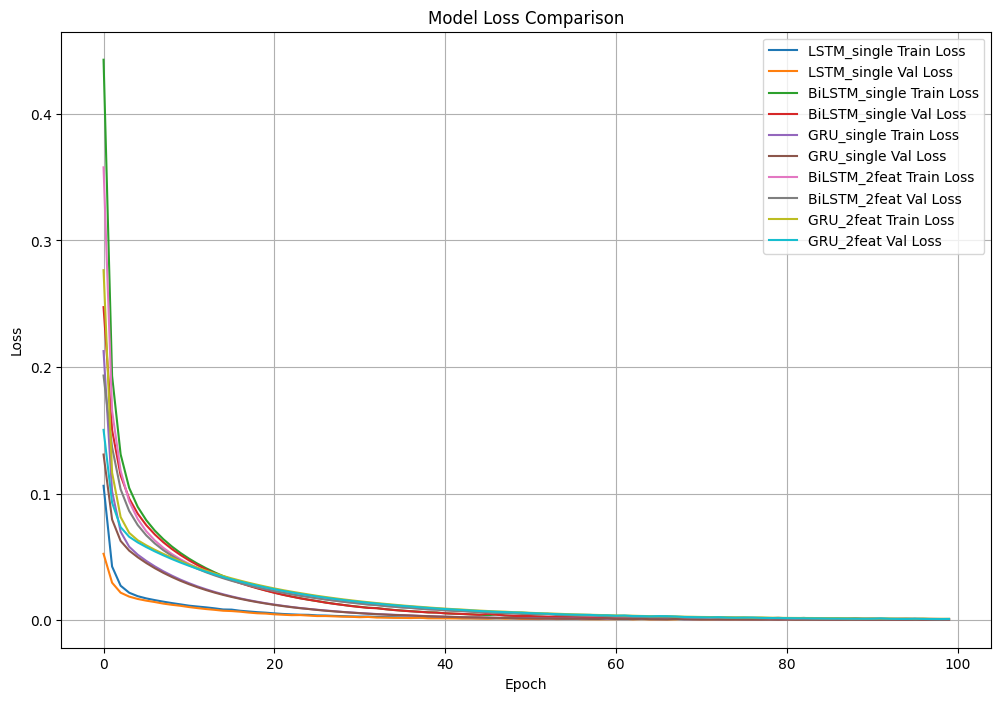

Performing rolling prediction with LSTM_single...
LSTM_single rolling prediction completed.

Performing rolling prediction with BiLSTM_single...
BiLSTM_single rolling prediction completed.

Performing rolling prediction with GRU_single...
GRU_single rolling prediction completed.

Performing rolling prediction with BiLSTM_2feat...
BiLSTM_2feat rolling prediction completed.

Performing rolling prediction with GRU_2feat...
GRU_2feat rolling prediction completed.



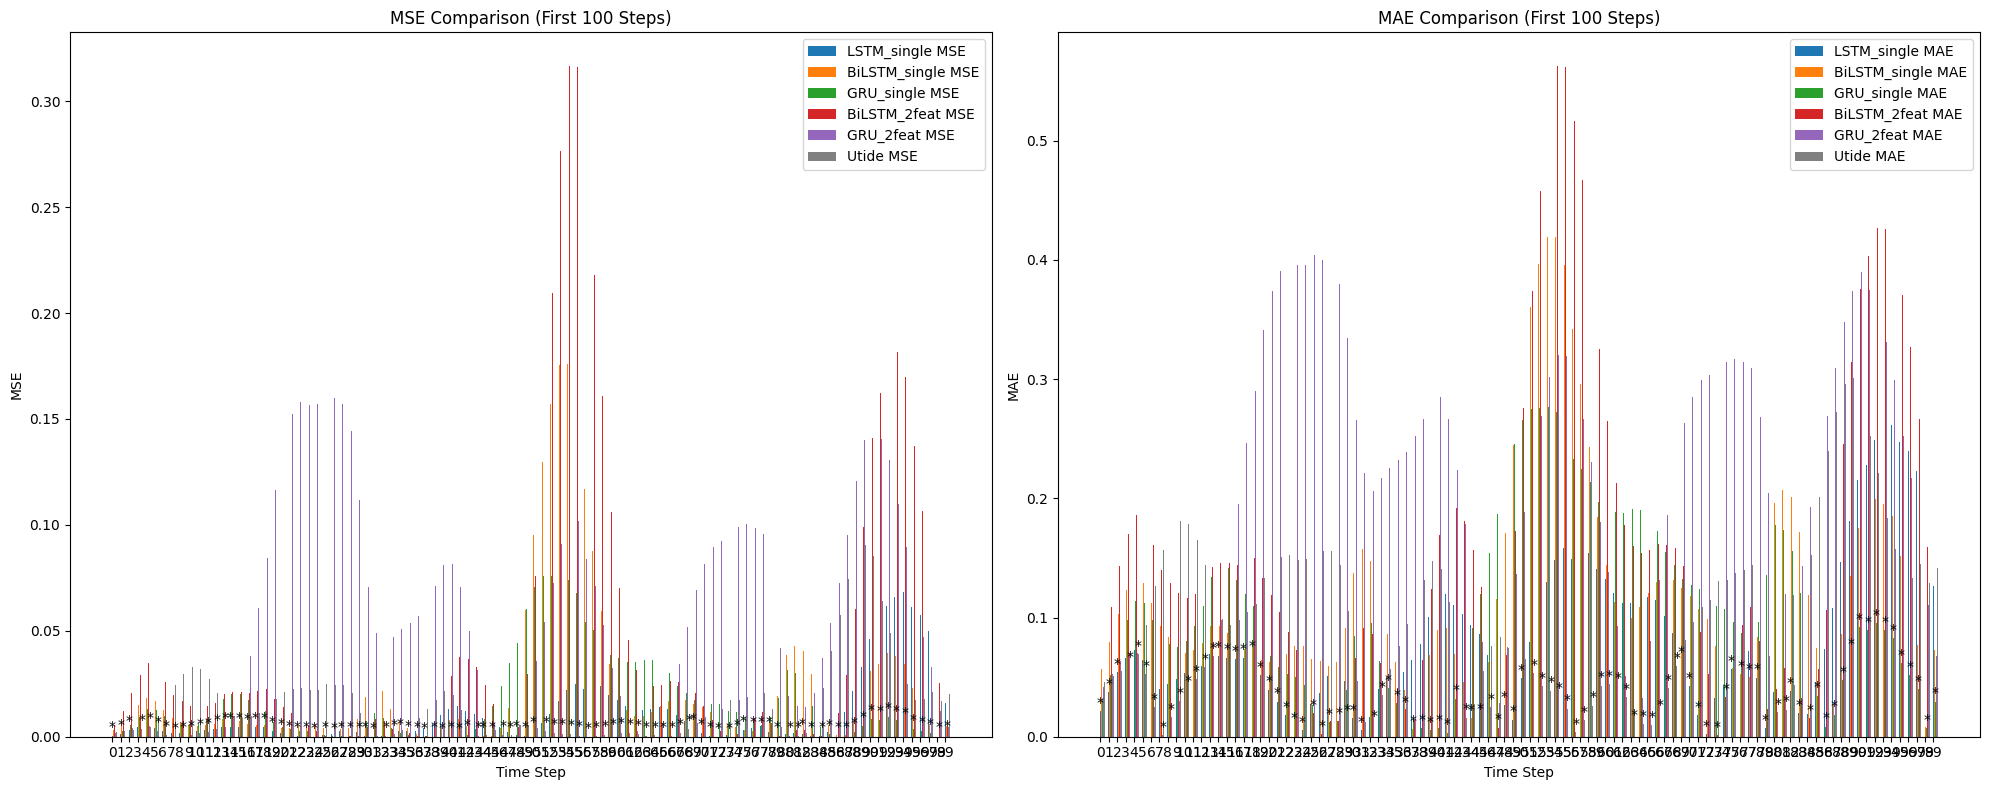

LSTM_single R² falls below Utide at step: 139
BiLSTM_single R² falls below Utide at step: 54
GRU_single R² falls below Utide at step: 76
BiLSTM_2feat R² falls below Utide at step: 20
GRU_2feat R² falls below Utide at step: 20


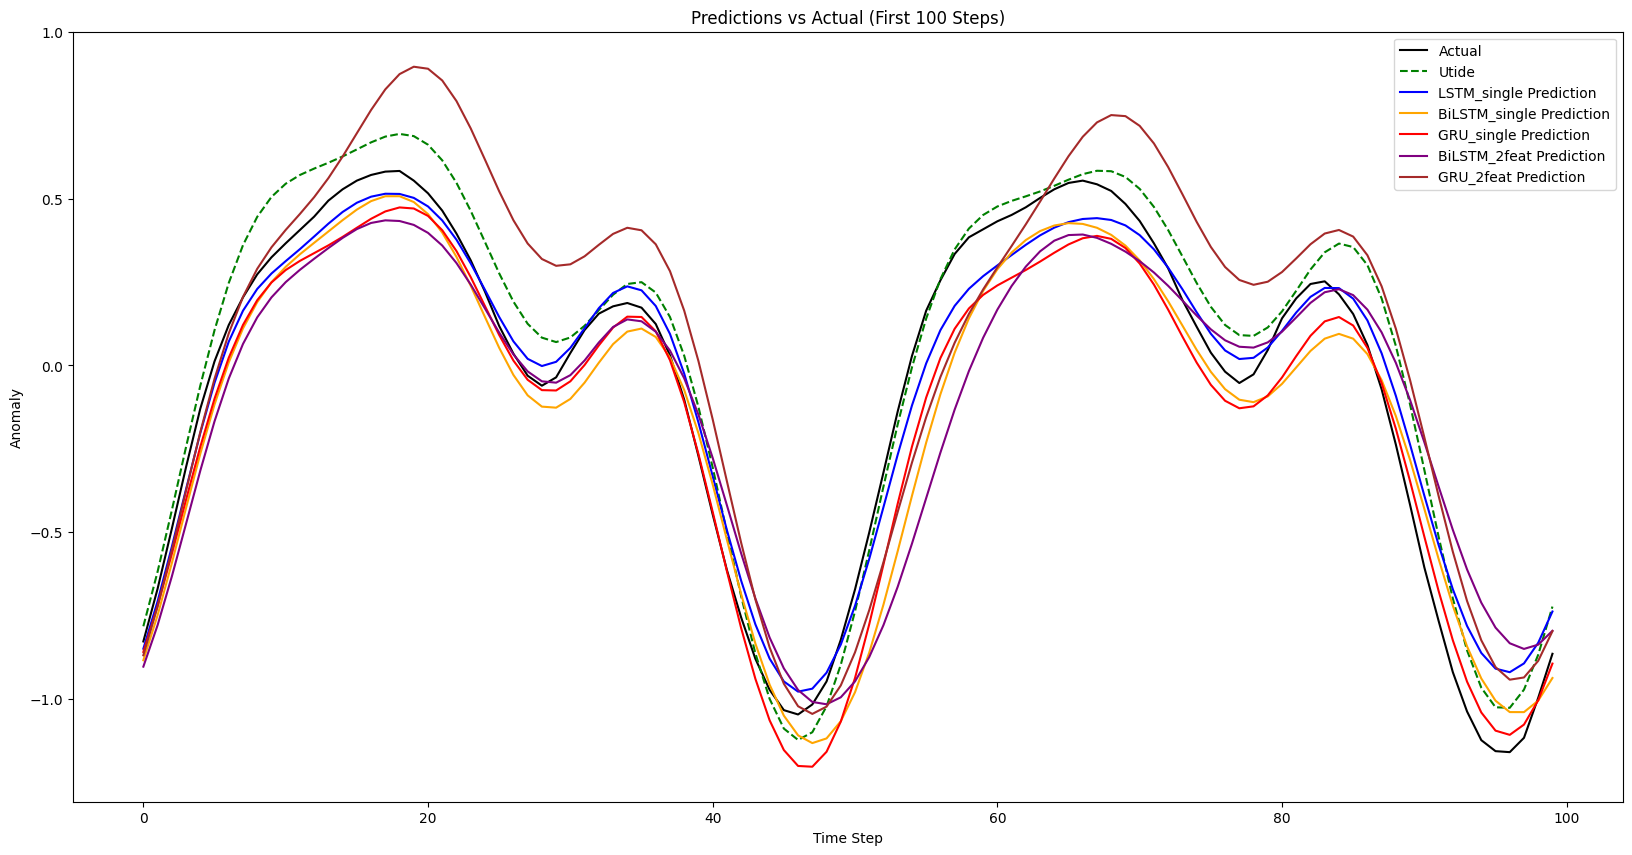

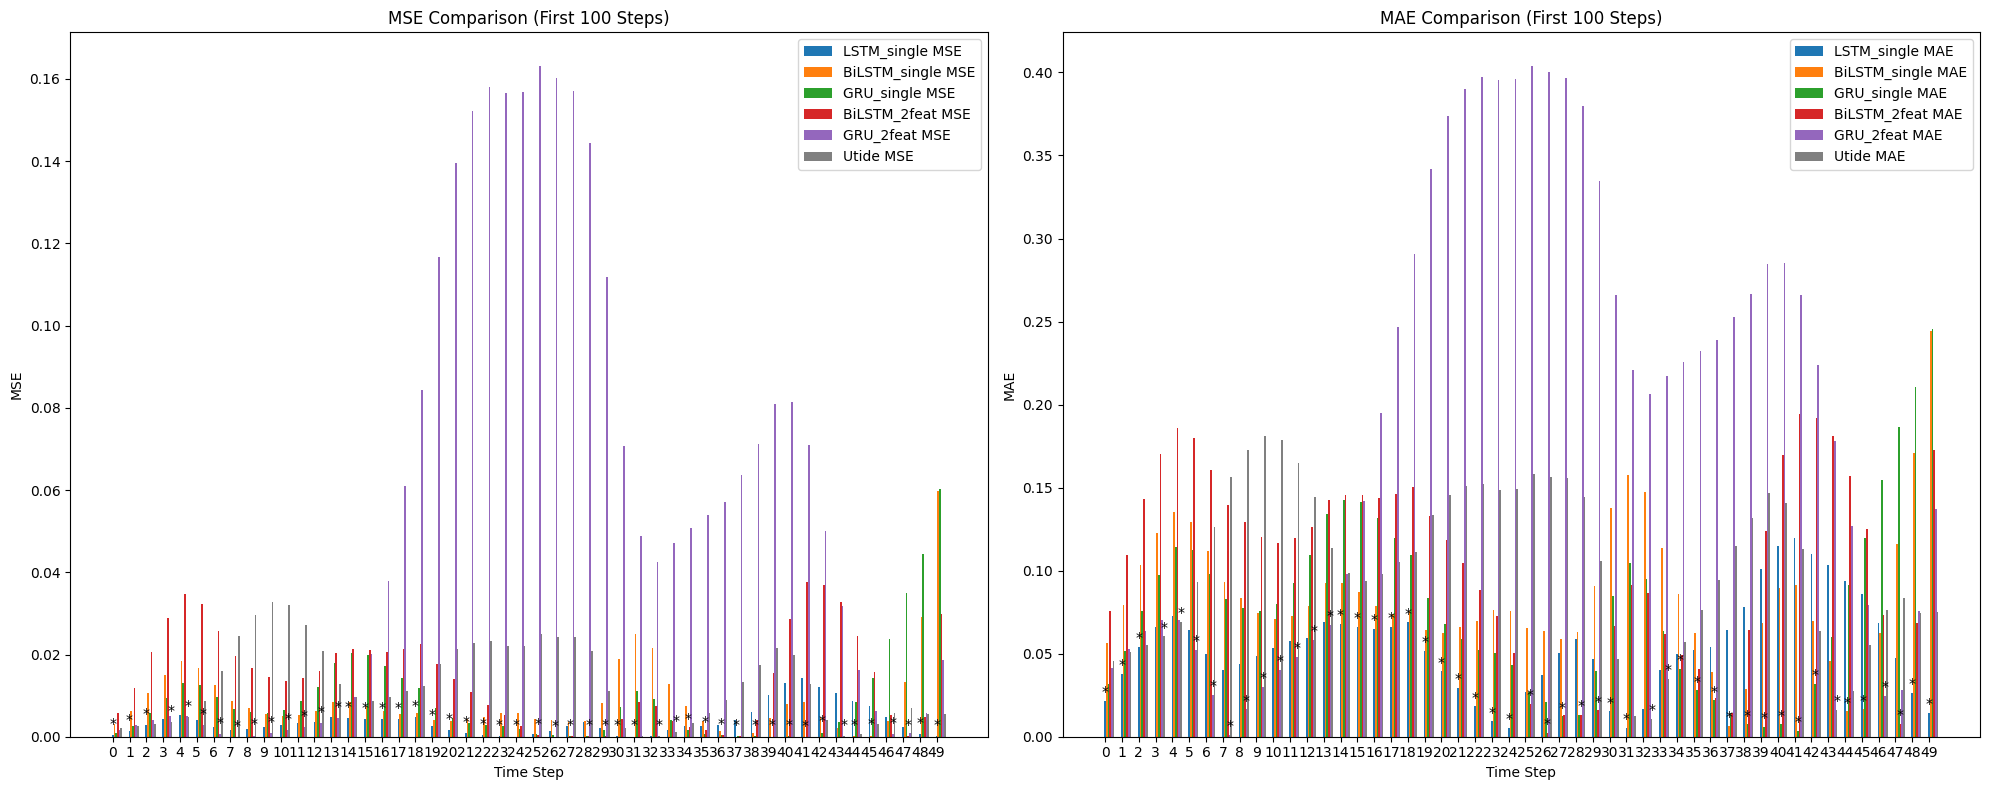

LSTM_single R² falls below Utide at step: 139
BiLSTM_single R² falls below Utide at step: 54
GRU_single R² falls below Utide at step: 76
BiLSTM_2feat R² falls below Utide at step: 20
GRU_2feat R² falls below Utide at step: 20


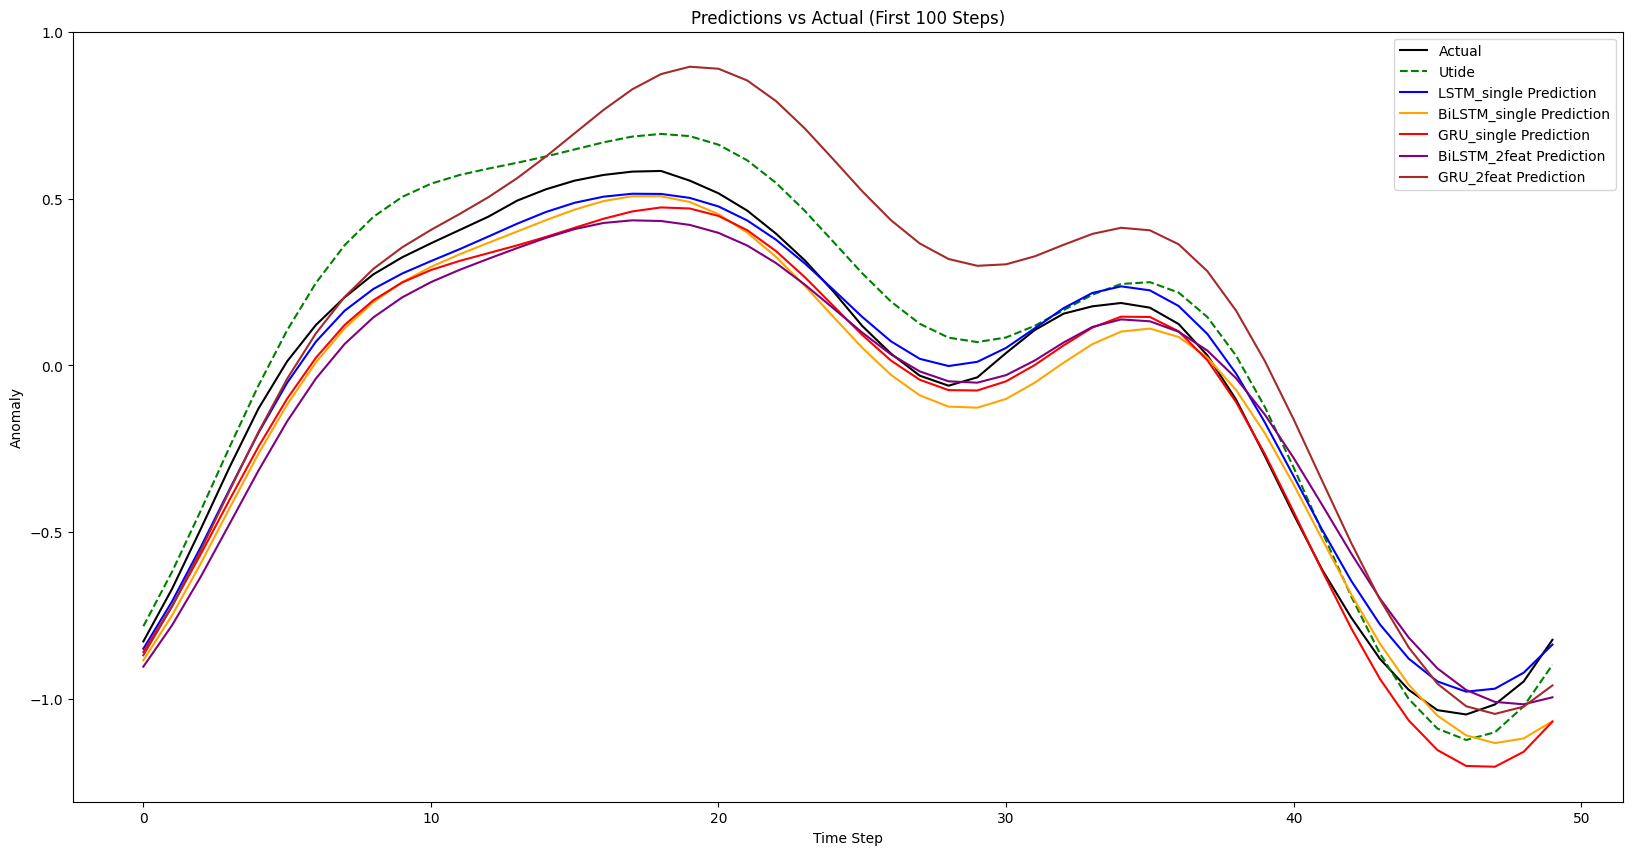

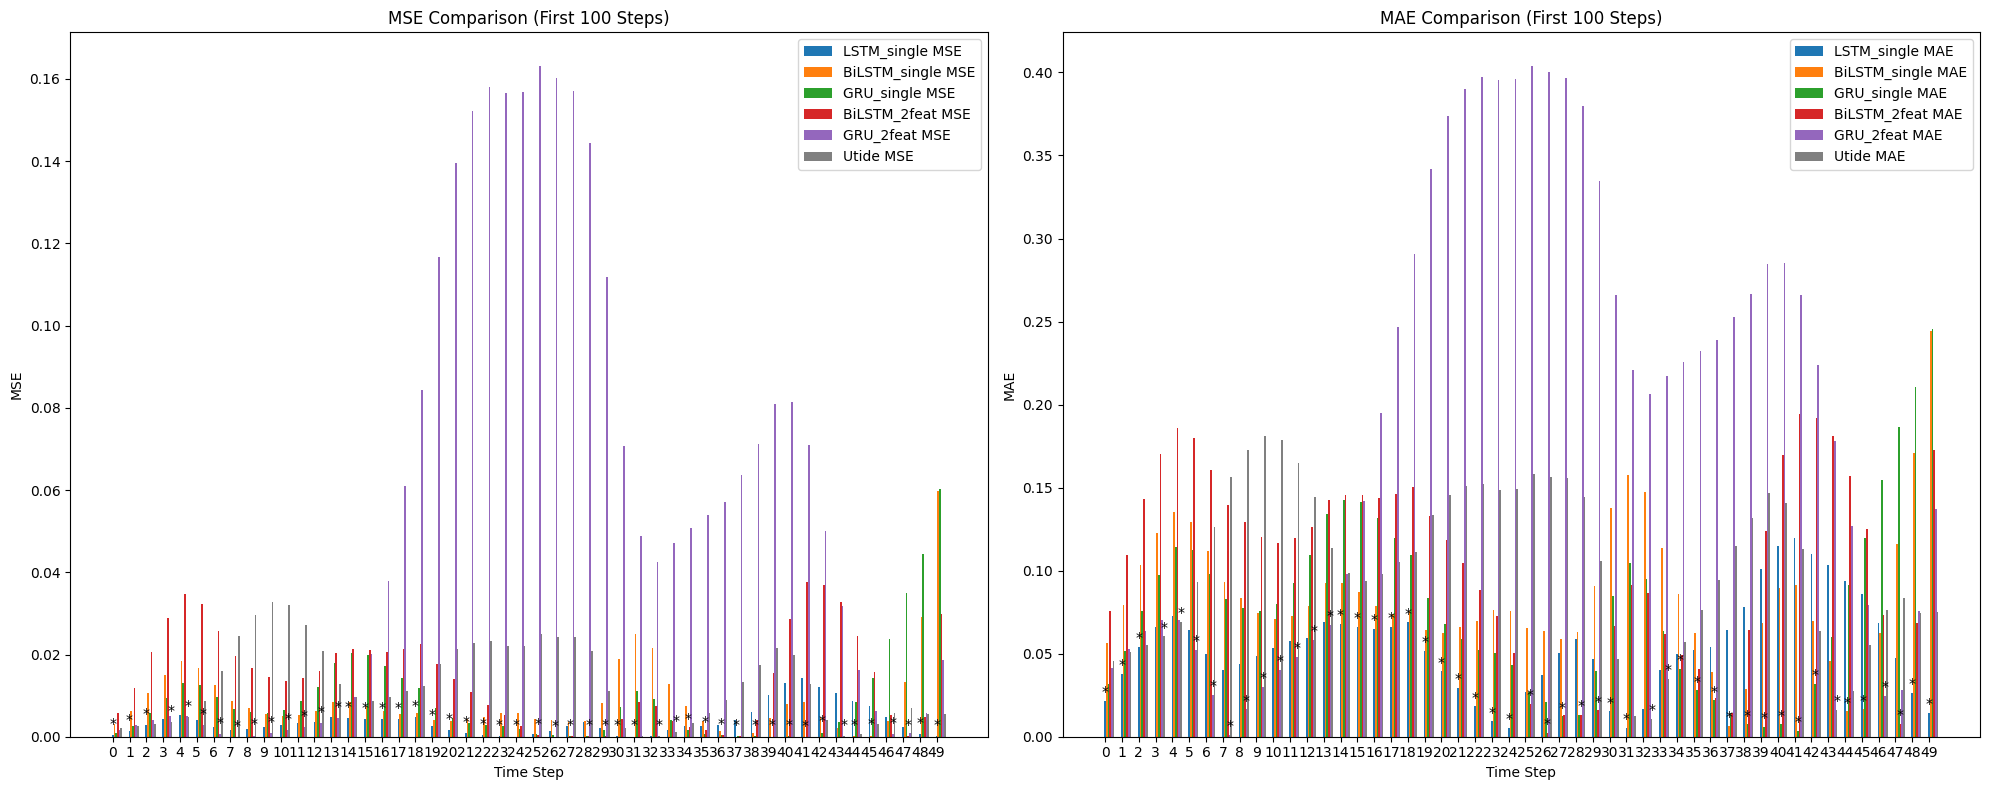

LSTM_single R² falls below Utide at step: 139
BiLSTM_single R² falls below Utide at step: 54
GRU_single R² falls below Utide at step: 76
BiLSTM_2feat R² falls below Utide at step: 20
GRU_2feat R² falls below Utide at step: 20


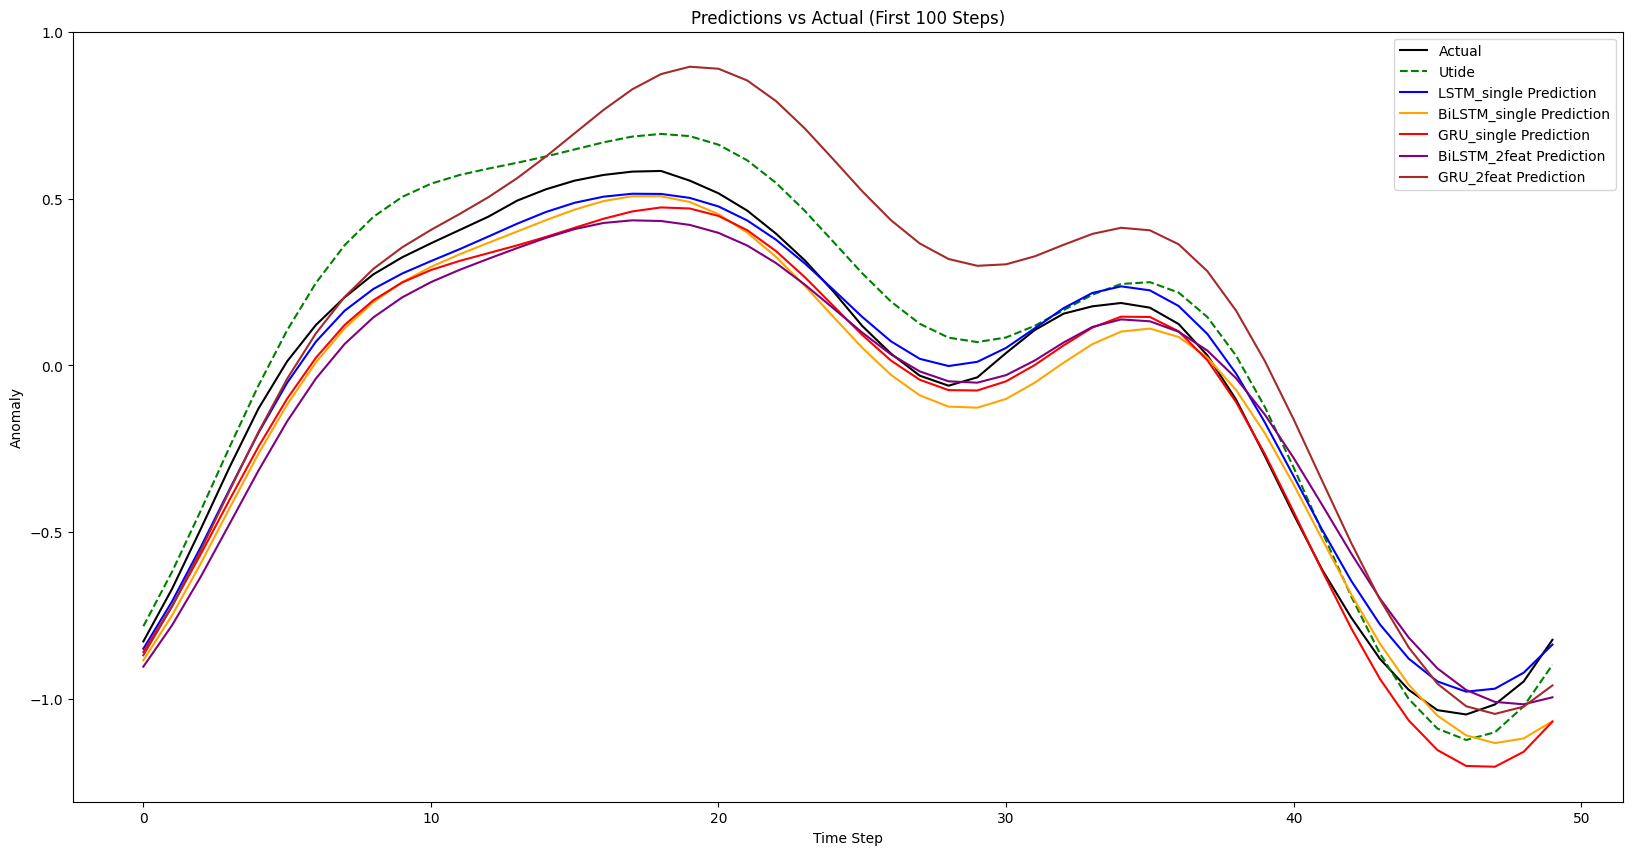

In [ ]:
steps_to_plot = 50
x = np.arange(steps_to_plot)
model_names = list(results.keys())
width = 0.1

mse_dict = {}
mae_dict = {}

for name in model_names:
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = results[name]['predicted_values'][:steps_to_plot]
    mse = (actual - predicted)**2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

mse_utide = (actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])**2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])

# mse mae hist
fig, axes = plt.subplots(1,2, figsize=(20,8))

# MSE
for idx, name in enumerate(model_names):
    axes[0].bar(x + idx*width, mse_dict[name], width, label=f'{name} MSE')
axes[0].bar(x + len(model_names)*width, mse_utide, width, label='Utide MSE', color='grey')
axes[0].set_title('MSE Comparison (First 100 Steps)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mse_dict[m][i] for m in model_names] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    axes[0].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

# MAE
for idx, name in enumerate(model_names):
    axes[1].bar(x + idx*width, mae_dict[name], width, label=f'{name} MAE')
axes[1].bar(x + len(model_names)*width, mae_utide, width, label='Utide MAE', color='grey')
axes[1].set_title('MAE Comparison (First 100 Steps)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mae_dict[m][i] for m in model_names] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    axes[1].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

for name in model_names:
    model_r2 = results[name]['r2_scores'][indices]
    falloff_indices = np.where(model_r2 < r2_utide)[0]
    first_falloff = falloff_indices[0] if falloff_indices.size > 0 else "Never"
    print(f"{name} R² falls below Utide at step: {first_falloff}")

#visual
plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')

colors = ['blue', 'orange', 'red', 'purple', 'brown']
for idx, name in enumerate(model_names):
    predicted = results[name]['predicted_values'][:steps_to_plot]
    plt.plot(predicted, label=f'{name} Prediction', color=colors[idx % len(colors)])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title('Predictions vs Actual (First 100 Steps)')
plt.legend()
plt.show()

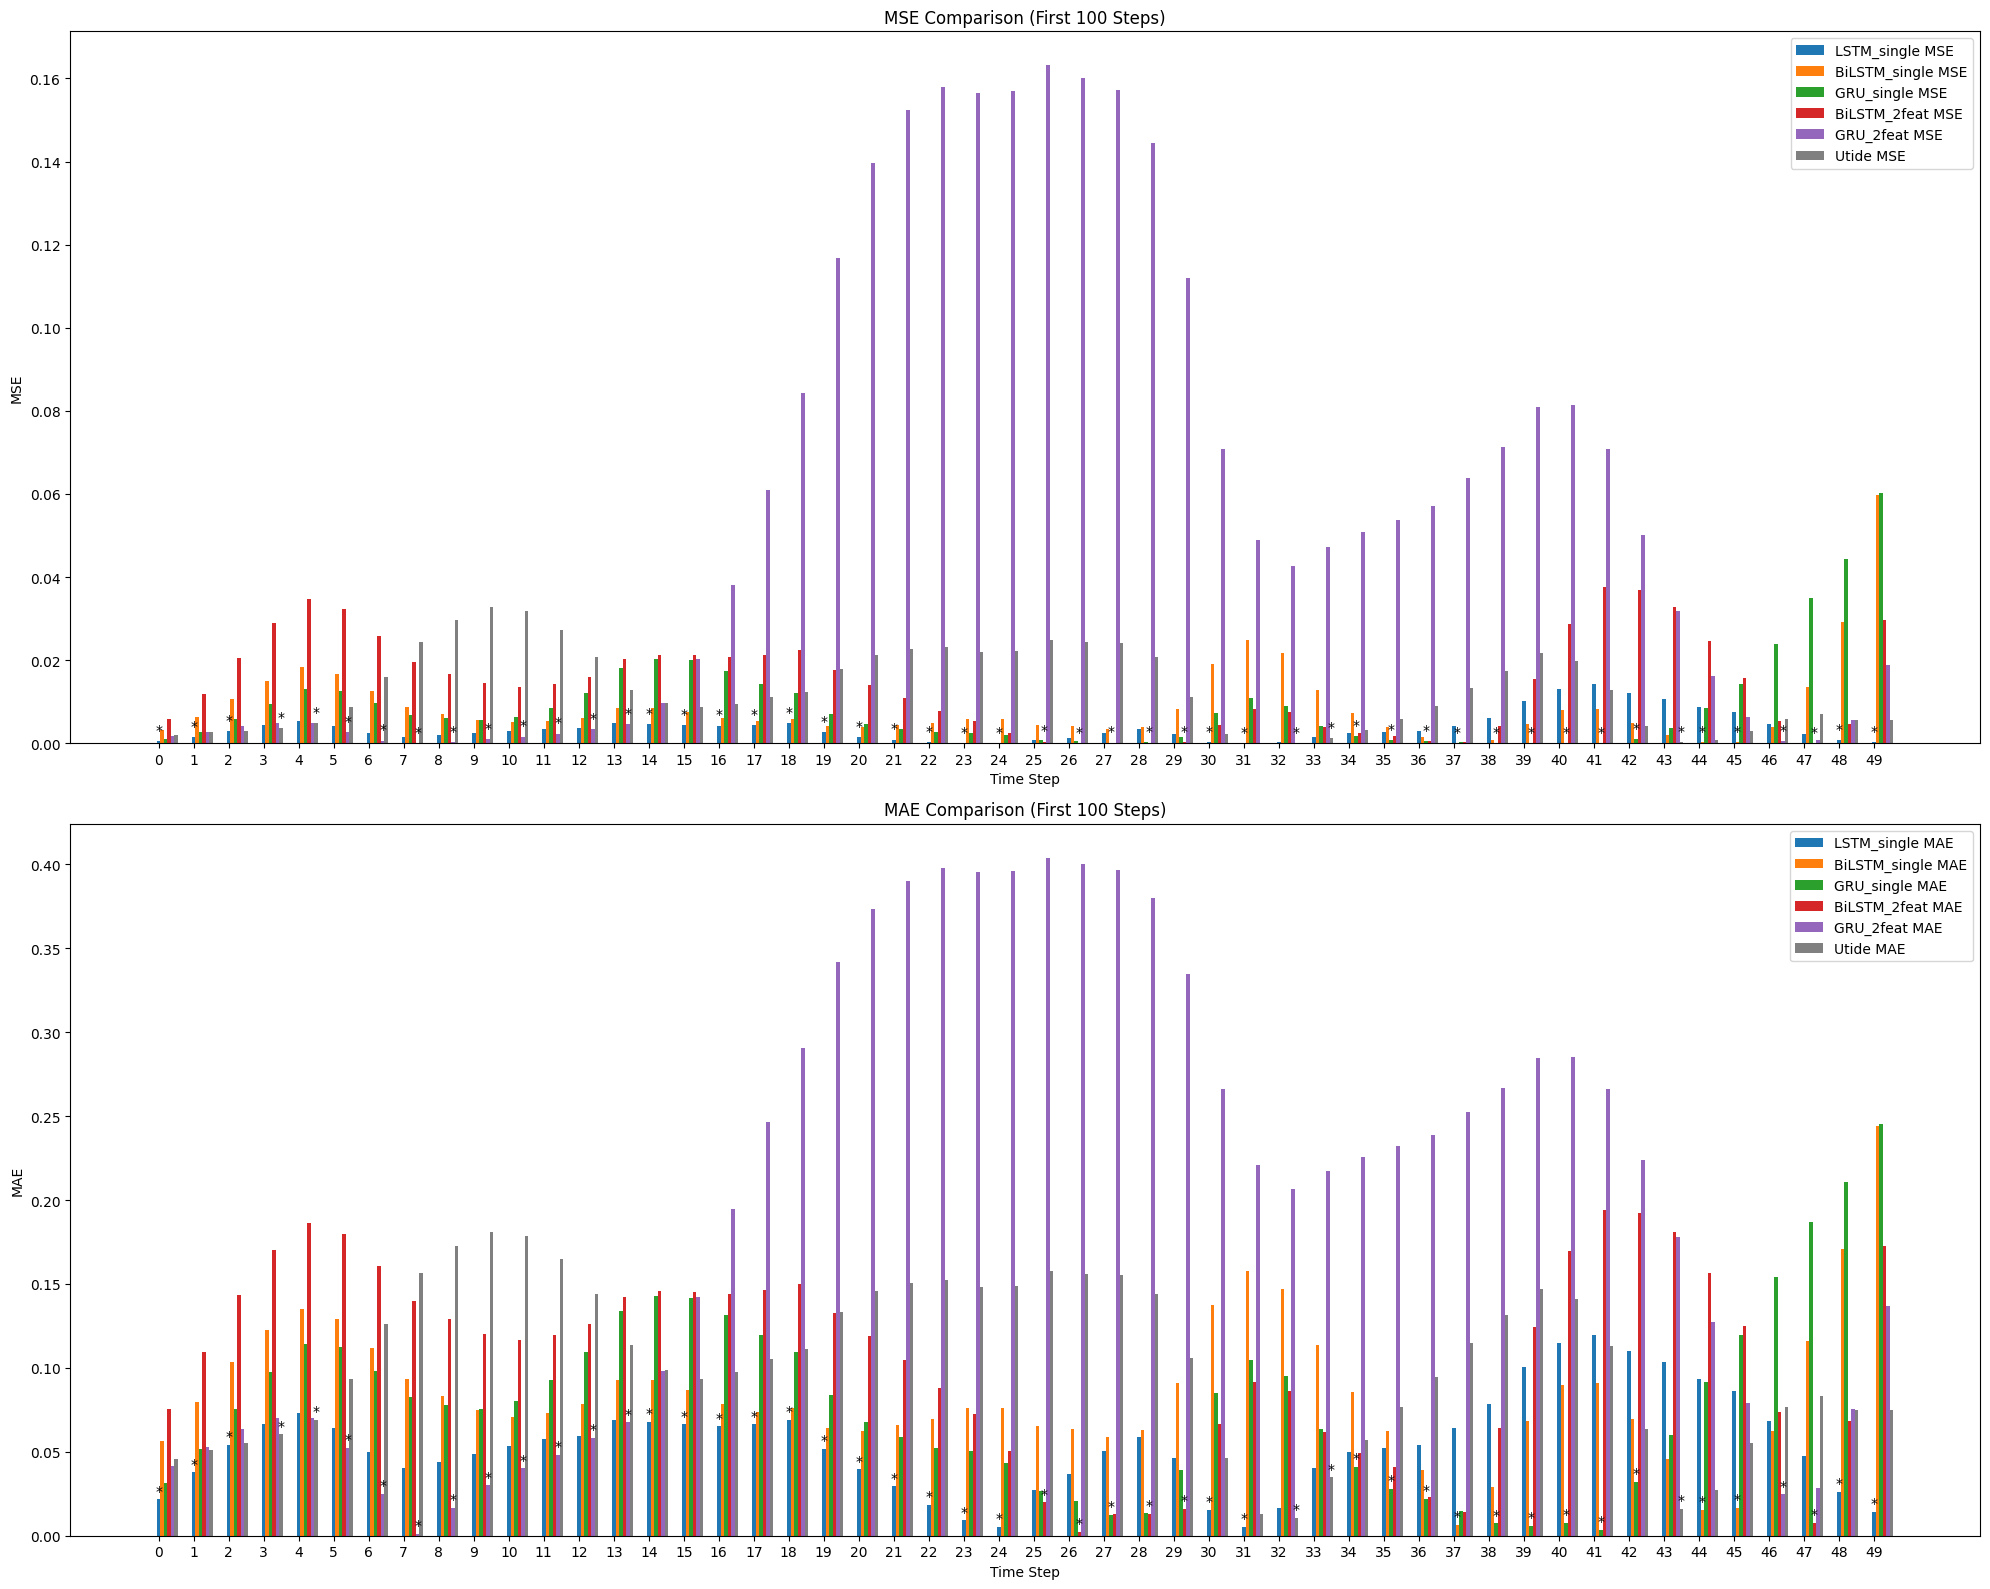

LSTM_single R² falls below Utide at step: 139
BiLSTM_single R² falls below Utide at step: 54
GRU_single R² falls below Utide at step: 76
BiLSTM_2feat R² falls below Utide at step: 20
GRU_2feat R² falls below Utide at step: 20


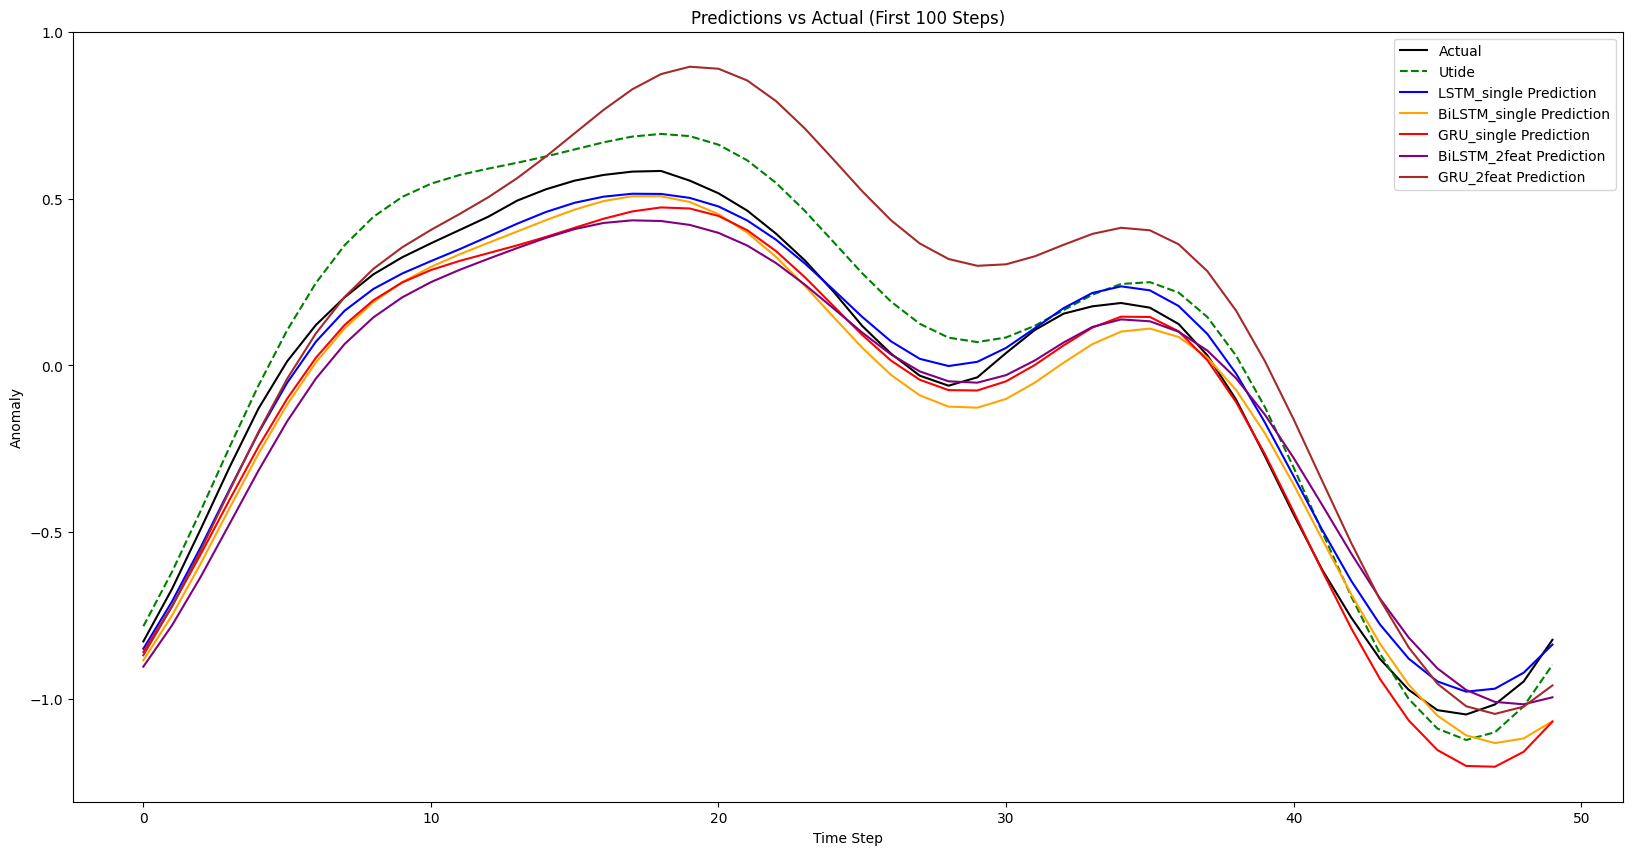

In [ ]:
steps_to_plot = 50
x = np.arange(steps_to_plot)
model_names = list(results.keys())
width = 0.1

mse_dict = {}
mae_dict = {}

for name in model_names:
    actual = results[name]['actual_values'][:steps_to_plot]
    predicted = results[name]['predicted_values'][:steps_to_plot]
    mse = (actual - predicted)**2
    mae = np.abs(actual - predicted)
    mse_dict[name] = mse
    mae_dict[name] = mae

mse_utide = (actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])**2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])

# mse mae historgram
fig, axes = plt.subplots(2, 1, figsize=(20, 16))

# MSE
for idx, name in enumerate(model_names):
    axes[0].bar(x + idx*width, mse_dict[name], width, label=f'{name} MSE')
axes[0].bar(x + len(model_names)*width, mse_utide, width, label='Utide MSE', color='grey')
axes[0].set_title('MSE Comparison (First 100 Steps)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mse_dict[m][i] for m in model_names] + [mse_utide[i]]
    min_idx = np.argmin(errors)
    axes[0].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

# MAE对比
for idx, name in enumerate(model_names):
    axes[1].bar(x + idx*width, mae_dict[name], width, label=f'{name} MAE')
axes[1].bar(x + len(model_names)*width, mae_utide, width, label='Utide MAE', color='grey')
axes[1].set_title('MAE Comparison (First 100 Steps)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mae_dict[m][i] for m in model_names] + [mae_utide[i]]
    min_idx = np.argmin(errors)
    axes[1].text(i + min_idx*width, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

for name in model_names:
    model_r2 = results[name]['r2_scores'][indices]
    falloff_indices = np.where(model_r2 < r2_utide)[0]
    first_falloff = falloff_indices[0] if falloff_indices.size > 0 else "Never"
    print(f"{name} R² falls below Utide at step: {first_falloff}")

plt.figure(figsize=(20, 10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')

colors = ['blue', 'orange', 'red', 'purple', 'brown']
for idx, name in enumerate(model_names):
    predicted = results[name]['predicted_values'][:steps_to_plot]
    plt.plot(predicted, label=f'{name} Prediction', color=colors[idx % len(colors)])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title('Predictions vs Actual (First 100 Steps)')
plt.legend()
plt.show()